# 03_SynopticConditions

Use ERA5 atmospheric reanalysis and PMW sea ice drift to evaluate synoptic conditions associated with different events

## Import packages

In [22]:
%load_ext autoreload
%autoreload 2

import numpy.ma as ma
import numpy as np
import xarray as xr
import pandas as pd

from datetime import datetime, timedelta

import cmocean
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import metpy
from metpy.units import units

import sys

# path to own functions
sys.path.append('../../')
import data_UniBremen.SIC as UNISIC
import data_UniBremen.MultiYearIce as UNIMYI

import data_NSIDC.icedrift as PPdrift



sys.path.append('../../Libraries_functions/')
from LIB_plotting import (add_colorbar)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from math import pi, cos, sin, atan, atan2


def ellipse_components(xc, yc, a, b, t_rot):
    
    # FOLLOWING:
    # https://stackoverflow.com/questions/10952060/plot-ellipse-with-matplotlib-pyplot
    
    # xc: x-position of the center of ellipse
    # yc: y-position of the center of ellipse
    
    # a (major axis of ellipse / radius on ellipse's x-axis), use:
    # SEm: standard error along mean wind direction ('m')
    
    # b (minor axis of ellipse / radius on ellipse's y-axis), use:
    # SEn: standard error perpendicular to mean wind direction ('n')
    
    # trot: rotation angle of ellipse
    
    # non-rotated ellipse paramterization
    t = np.linspace(0, 2*pi, 100)
    Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
    R_rot = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
    
    #2-D rotation matrix
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

    # rotated ellipse components
    x = Ell_rot[0,:] #+ xc
    y = Ell_rot[1,:] #+ yc
    
    return x, y



def create_SDellipses(atmdata):
    
    # mean wind direction components in x,y (lon, lat)
    mean_x = np.mean(atmdata['u10'].values)
    mean_y = np.mean(atmdata['v10'].values)
    mean_mag = np.sqrt(mean_x**2+mean_y**2)
    theta = atan2(mean_y, mean_x)

    # component along mean wind (call this 'm' direction)
    comp_m = (atmdata['u10'].values * mean_x + atmdata['v10'].values * mean_y) / mean_mag
    comp_n = (-atmdata['u10'].values * mean_y + atmdata['v10'].values * mean_x) / mean_mag

    SEm = np.std(comp_m) #/ np.sqrt(len(comp_m))
    SEn = np.std(comp_n) #/ np.sqrt(len(comp_n))

    x, y = ellipse_components(mean_x, mean_y, SEm, SEn, theta)
    
    return x,y


def create_SDellipses(u, v):
    
    # mean wind direction components in x,y (lon, lat)
    mean_x = np.mean(u)
    mean_y = np.mean(v)
    mean_mag = np.sqrt(mean_x**2+mean_y**2)
    theta = atan2(mean_y, mean_x)

    # component along mean wind (call this 'm' direction)
    comp_m = (u * mean_x + v * mean_y) / mean_mag
    comp_n = (-u * mean_y + v * mean_x) / mean_mag

    SEm = np.std(comp_m) #/ np.sqrt(len(comp_m))
    SEn = np.std(comp_n) #/ np.sqrt(len(comp_n))

    x, y = ellipse_components(mean_x, mean_y, SEm, SEn, theta)
    
    return x,y

### Import bathymetry data

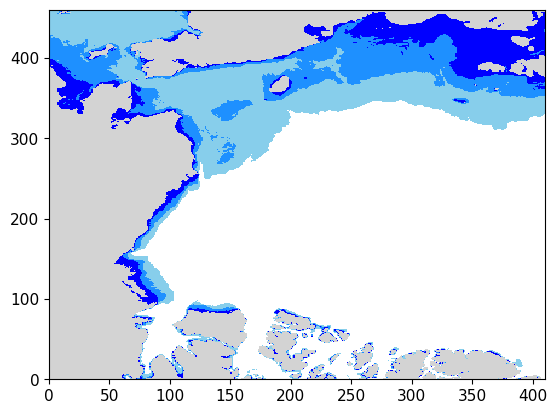

In [2276]:
# open example sic data
sic = UNISIC.open_local_file(date, res = '6250', hem = 'n',
                              area = False, include_units=False)

ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/re-gridded/master_625kmASI_V1.nc')
ds.close()

ai,aj = 720,1180
bi,bj = 190,600
XX = sic['xx'][ai:aj, bi:bj]
YY = sic['yy'][ai:aj, bi:bj]

# LAND = np.full(data['sic']['xx'].shape, False)
# LAND_CROP = ds.mean_z.values >= 0
LAND = (ds.avg.values >= 0)[ai:aj, bi:bj]

# INNER = np.full(data['sic']['xx'].shape, False)
INNER = ((ds.avg.values >= -20) & (ds.avg.values < 0))[ai:aj, bi:bj]

# MID = np.full(data['sic']['xx'].shape, False)
MID = ((ds.avg.values >= -40) & (ds.avg.values < -20))[ai:aj, bi:bj]

# OUTER = np.full(data['sic']['xx'].shape, False)
OUTER = ((ds.avg.values >= -100) & (ds.avg.values < -40))[ai:aj, bi:bj]


%matplotlib inline
fig, ax = plt.subplots()
ax.pcolormesh(LAND, cmap=matplotlib.colors.ListedColormap(['None', 'lightgray']))
ax.pcolormesh(INNER, cmap=matplotlib.colors.ListedColormap(['None', 'blue']))
ax.pcolormesh(MID, cmap=matplotlib.colors.ListedColormap(['None', 'dodgerblue']))
ax.pcolormesh(OUTER, cmap=matplotlib.colors.ListedColormap(['None', 'skyblue']))


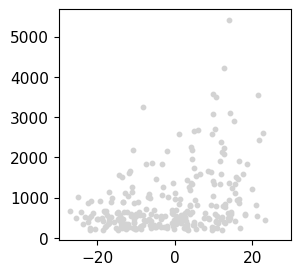

In [3046]:
df2 = pd.read_csv('../data/PMWopen70_extents_20032024.csv')

all_dates = pd.to_datetime(df2.date.values)
all_dates


total_event_areas = np.array([])

for date in np.append(events['lfbo_open']['date'], events['flaw_open']['date']):
    
    # find date index
    dat_ind = np.where(all_dates==date)[0][0]
    
    total_area = df2['inner'].values[dat_ind] + df2['middle'].values[dat_ind]
    total_event_areas = np.append(total_event_areas, total_area)
    
    

all_event_ug = np.append(region_atm['lfbo_open']['ug'], region_atm['flaw_open']['ug'])
all_event_vg = np.append(region_atm['lfbo_open']['vg'], region_atm['flaw_open']['vg'])
all_event_speed = np.sqrt(all_event_vg**2+all_event_ug**2)

fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(-30,30)
ax.scatter(all_event_ug, total_event_areas, s=10, c='lightgray')


In [3150]:
months = [1,2,3]
years = np.append(np.arange(2003,2012),np.arange(2013,2025))

events = {}

events['lfbo_open'] = {}
events['lfbo_distinct'] = {}
events['lfbo'] = {}
events['flaw_open'] = {}
events['flaw_distinct'] = {}
events['flaw'] = {}
events['clim'] = {}

version = 'v11'
events['lfbo']['date'] = pd.to_datetime(pd.read_csv(f'../data/lfbo_new_{version}.csv').dates.values)
events['lfbo']['area'] = pd.read_csv(f'../data/lfbo_new_{version}.csv').area.values

events['lfbo_open']['date'] = pd.to_datetime(pd.read_csv(f'../data/lfbo_open_{version}.csv').dates.values)
events['lfbo_open']['area'] = pd.read_csv(f'../data/lfbo_open_{version}.csv').area.values

events['lfbo_distinct']['date'] = pd.to_datetime(pd.read_csv(f'../data/lfbo_distinct_{version}.csv').dates.values)
events['lfbo_distinct']['area'] = pd.read_csv(f'../data/lfbo_distinct_{version}.csv').area.values

events['flaw']['date'] = pd.to_datetime(pd.read_csv(f'../data/flaw_new_{version}.csv').dates.values)
events['flaw']['area'] = pd.read_csv(f'../data/flaw_new_{version}.csv').area.values

events['flaw_open']['date'] = pd.to_datetime(pd.read_csv(f'../data/flaw_open_{version}.csv').dates.values)
events['flaw_open']['area'] = pd.read_csv(f'../data/flaw_open_{version}.csv').area.values

events['flaw_distinct']['date'] = pd.to_datetime(pd.read_csv(f'../data/flaw_distinct_{version}.csv').dates.values)
events['flaw_distinct']['area'] = pd.read_csv(f'../data/flaw_distinct_{version}.csv').area.values

# record across other dates to so as not to cut off events occurring 
# at time domain bounds
record_all = {}
record_all['lfbo'] = np.copy(events['lfbo']['date'])
record_all['flaw'] = np.copy(events['flaw']['date'])
record_all['lfbo_open'] = np.copy(events['lfbo_open']['date'])
record_all['flaw_open'] = np.copy(events['flaw_open']['date'])



for cat in ['lfbo_open', 'lfbo', 'flaw', 'flaw_open', 'flaw_distinct', 'lfbo_distinct']:
    events[cat]['area'] = events[cat]['area'][(events[cat]['date'].month<4)]
    events[cat]['date'] = events[cat]['date'][(events[cat]['date'].month<4)]

# save clime dates
clim_dates = np.array([], dtype='datetime64[ns]')
for year in years:
    clim_dates = np.append(clim_dates, pd.date_range(datetime(year, 1, 1), datetime(year, 3, 31)))
clim_dates = pd.to_datetime(clim_dates)
print(f'{len(clim_dates)} clim_dates')
    
events['clim']['date'] = clim_dates


1895 clim_dates


In [3151]:
print('open:')
print(len(events['lfbo_open']['date']))
print(len(events['flaw_open']['date']))

print('\nnew events:')
print(len(events['lfbo']['date']))
print(len(events['flaw']['date']))

print('\nodistinct:')
print(len(events['lfbo_distinct']['date']))
print(len(events['flaw_distinct']['date']))

open:
117
143

new events:
76
96

odistinct:
39
63


In [3152]:

dt = np.arange(-8,9)
assoc_counts = {}
assoc_counts['flaw_fromlfbo'] = np.zeros(len(dt))
assoc_counts['lfbo_fromflaw'] = np.zeros(len(dt))

assoc_counts['flaw_fromflaw'] = np.zeros(len(dt))
assoc_counts['lfbo_fromlfbo'] = np.zeros(len(dt))

for date in events['flaw_distinct']['date']:
    for dd in range(len(dt)):
        if date + timedelta(days=int(dt[dd])) in record_all['lfbo_open']:#events['lfbo']['date']:
            assoc_counts['lfbo_fromflaw'][dd] += 1
        if date + timedelta(days=int(dt[dd])) in record_all['flaw_open']:#events['lfbo']['date']:
            assoc_counts['flaw_fromflaw'][dd] += 1
            
for date in events['lfbo_distinct']['date']:
    for dd in range(len(dt)):
        if date + timedelta(days=int(dt[dd])) in record_all['flaw_open']:#events['flaw']['date']:
            assoc_counts['flaw_fromlfbo'][dd] += 1 
        if date + timedelta(days=int(dt[dd])) in record_all['lfbo_open']:#events['lfbo']['date']:
            assoc_counts['lfbo_fromlfbo'][dd] += 1

            
bg_likely = {}
bg_likely['flaw'] = 100*len(events['flaw_open']['date']) / len(events['clim']['date'])
bg_likely['lfbo'] = 100*len(events['lfbo_open']['date']) / len(events['clim']['date'])



assoc_likely = {}
assoc_likely['flaw_fromlfbo'] = (100*assoc_counts['flaw_fromlfbo']/len(events['lfbo_distinct']['date'])) #/ bg_likely['flaw']
assoc_likely['lfbo_fromflaw'] = (100*assoc_counts['lfbo_fromflaw']/len(events['flaw_distinct']['date'])) #/ bg_likely['lfbo']

assoc_likely['flaw_fromflaw'] = (100*assoc_counts['flaw_fromflaw']/len(events['flaw_distinct']['date'])) #/ bg_likely['flaw']
assoc_likely['lfbo_fromlfbo'] = (100*assoc_counts['lfbo_fromlfbo']/len(events['lfbo_distinct']['date'])) #/ bg_likely['lfbo']




Text(-8.25, 12, '6%')

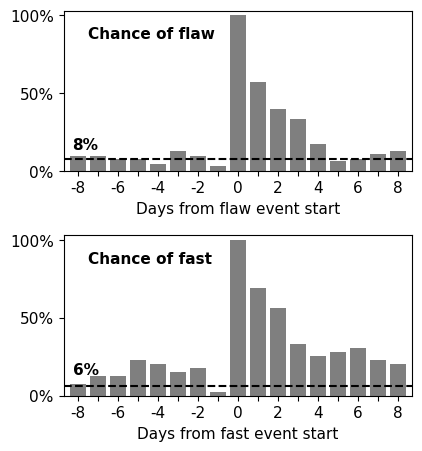

In [3153]:
plt.rcParams.update({'font.size': 11})

fig, axs = plt.subplots(2, 1, figsize=(4.5,5))

plt.subplots_adjust(hspace=0.4)

xticks = [f'{tick}' if tick%2==0 else f'' for tick in dt]

for ax in axs:
    ax.set_ylim(0,103)
    ax.set_xlim(dt.min()-0.7, dt.max()+0.7)
    ax.set_xticks(dt)
    ax.set_xticklabels(xticks)
    ax.set_yticks([0,50,100])
    ax.set_yticklabels(['0%','50%','100%',])
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.tick_params(axis='both', which='minor', labelsize=8)


color = 'k'
# color = [0.7,0.7,0.7]
H = 12

ax = axs[0]
ax.set_xlabel('Days from flaw event start')
ax.text(-7.5,85, 'Chance of flaw', c=color, ha='left', weight='bold', clip_on=False)
ax.bar(dt, assoc_likely['flaw_fromflaw'], color=color,alpha=0.5)
ax.axhline(bg_likely['flaw'], linestyle='dashed',  c=color)
ax.text(-8.25,H,f"{bg_likely['flaw']:.0f}%", va='bottom', ha='left', c=color, weight='bold')

ax = axs[1]
ax.set_xlabel('Days from fast event start')
ax.text(-7.5,85, 'Chance of fast', c=color, ha='left', weight='bold', clip_on=False)
ax.bar(dt, assoc_likely['lfbo_fromlfbo'], color=color,alpha=0.5)
ax.axhline(bg_likely['lfbo'], linestyle='dashed',  c=color)
ax.text(-8.25,H,f"{bg_likely['lfbo']:.0f}%", va='bottom', ha='left', c=color, weight='bold')


# ax = axs[0]
# ax.text(-7.5,70, 'Chance of fast', c=[0.3,0.3,0.3], ha='left', weight='bold', clip_on=False, zorder=1)
# ax.bar(dt, assoc_likely['lfbo_fromflaw'], color=[0.3,0.3,0.3],zorder=3)
# ax.axhline(bg_likely['lfbo'], linestyle='dashed',  c='k',zorder=3)
# ax.text(-6.75,H,f"{bg_likely['lfbo']:.0f}%", va='bottom', ha='left', c='k', weight='bold')

# ax = axs[1]
# ax.bar(dt, assoc_likely['flaw_fromlfbo'], color=[0.3,0.3,0.3], alpha=1, zorder=2)
# ax.text(-7.5,70, 'Chance of flaw', c=[0.3,0.3,0.3], ha='left', weight='bold', clip_on=False, zorder=1)
# ax.axhline(bg_likely['flaw'], linestyle='dashed', c='k')
# ax.text(-6.75,H,f"{bg_likely['flaw']:.0f}%", va='bottom', ha='left', c='k', weight='bold')


# ax = axs[0]
# for t in [1,2,3]:
#     y = assoc_likely['flaw_fromflaw'][np.where(dt==t)][0]
#     ax.text(t,y,f" {y:.0f}%", va='bottom', ha='center', c=color, weight='bold', size=6)
# ax = axs[1]
# for t in [1,2,3,4,5,6]:
#     y = assoc_likely['lfbo_fromlfbo'][np.where(dt==t)][0]
#     ax.text(t,y,f" {y:.0f}%", va='bottom', ha='center', c=color, weight='bold', size=6)



# for t in [1,2,3]:
#     y = assoc_likely['lfbo_fromflaw'][np.where(dt==t)][0]
#     ax.text(t,y,f"{y:.0f}%", va='bottom', ha='center', c='k', weight='bold', size=6.5)
# for t in [-3,-2,-1]:
#     y = assoc_likely['flaw_fromlfbo'][np.where(dt==t)][0]
#     ax.text(t,y,f"{y:.0f}%", va='bottom', ha='center', c='k', weight='bold', size=6.5)

# fig.savefig('./figures/EventChances_v1.png', dpi=400, bbox_inches='tight', pad_inches = 0)

In [3154]:
counts = {}
counts['month'] = {}
counts['year'] = {}

for key in ['lfbo', 'flaw', 'lfbo_open', 'flaw_open', 'lfbo_distinct', 'flaw_distinct' ]:
    counts['month'][key] = np.array([np.sum(events[key]['date'].month == month) for month in months])
    counts['year'][key] = np.array([np.sum(events[key]['date'].year == year) for year in years])

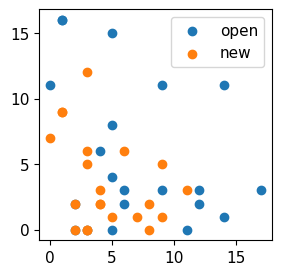

In [3155]:
fig, ax = plt.subplots(figsize=(3,3))
plt.scatter(counts['year']['flaw_open'], counts['year']['lfbo_open'], label='open')
plt.scatter(counts['year']['flaw'], counts['year']['lfbo'], label='new')
plt.legend()

In [3156]:
flaw_color

[0.675, 0.85, 1]

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3213/2851811002.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(1,1, c=colrs['flaw_open_dark'])


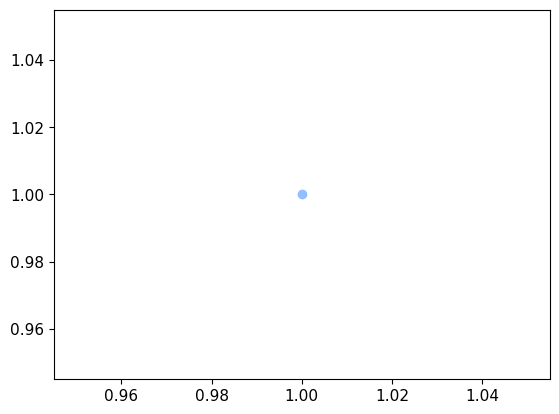

In [3732]:
colrs = {}
colrs['lfbo_open'] = [1, 0.825, 0.525]
colrs['flaw_open'] = [0.675, 0.85, 1]
colrs['lfbo_open_dark'] = [1, 0.725, 0.425]
colrs['flaw_open_dark'] = [0.575, 0.75, 1]
plt.scatter(1,1, c=colrs['flaw_open_dark'])

In [3196]:
np.nanmedian(counts['year']['flaw_open'])

5.0

In [3197]:
np.nanmedian(counts['year']['lfbo_open'])

3.0

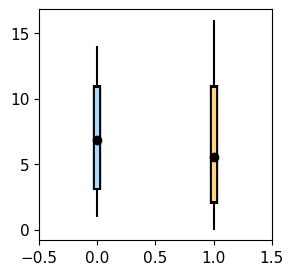

In [3238]:
fig, ax = plt.subplots(figsize=(3,3))

ax.set_xlim(-0.5,1.5)

x = 0
group = 'flaw_open'
ax.scatter(x, np.nanmean(counts['year'][group]), zorder=2, c='k')
ax.vlines(x, np.nanpercentile(counts['year'][group], 25), 
           np.nanpercentile(counts['year'][group], 75), linewidths=6, colors='k', zorder=0)
ax.vlines(x, np.nanpercentile(counts['year'][group], 25)+0.2, 
           np.nanpercentile(counts['year'][group], 75)-0.2, linewidths=3, colors=flaw_color, zorder=0)
ax.vlines(x, np.nanpercentile(counts['year'][group], 5), 
           np.nanpercentile(counts['year'][group], 95), colors='k', zorder=-1)


x = 1
group = 'lfbo_open'
ax.scatter(x, np.nanmean(counts['year'][group]), zorder=2, c='k')
ax.vlines(x, np.nanpercentile(counts['year'][group], 25), 
           np.nanpercentile(counts['year'][group], 75), linewidths=6, colors='k', zorder=0)
ax.vlines(x, np.nanpercentile(counts['year'][group], 25)+0.2, 
           np.nanpercentile(counts['year'][group], 75)-0.2, linewidths=3, colors=lfbo_color, zorder=0)
ax.vlines(x, np.nanpercentile(counts['year'][group], 5), 
           np.nanpercentile(counts['year'][group], 95), colors='k', zorder=-1)




In [3241]:
group = 'lfbo_open'
np.nanmean(counts['year'][group]), np.nanmedian(counts['year'][group])

(5.571428571428571, 3.0)

In [3242]:
group = 'flaw_open'
np.nanmean(counts['year'][group]), np.nanmedian(counts['year'][group])

(6.809523809523809, 5.0)

In [3243]:
np.nanpercentile(counts['year'][group], 25)
np.nanpercentile(counts['year'][group], 75)

11.0

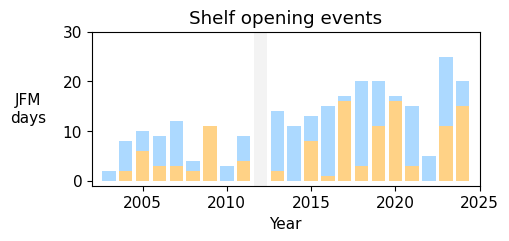

In [3356]:
fig, ax = plt.subplots(figsize=(5,2))

ax.set_ylim(-1,30)
ax.set_xlim(2002,2025)
ax.set_yticks([0,10,20,30])
ax.set_title('Shelf opening events')
ax.set_ylabel('JFM\ndays', rotation=0, labelpad = 25, va='center')
ax.set_xlabel('Year')
ax.bar(2012, 47, bottom=-2, color='lightgray', alpha=0.25)


ax.bar(years, counts['year']['lfbo_open'], color = colrs['lfbo_open'])

ax.bar(years, counts['year']['flaw_open'], bottom=counts['year']['lfbo_open'], color=colrs['flaw_open'])

# ax.bar(years, counts['year']['lfbo_open']+counts['year']['flaw_open'], color='gray')


fig.savefig('./figures/ShelfEventsTimeseries_v2.png', dpi=400, bbox_inches='tight', pad_inches=0)





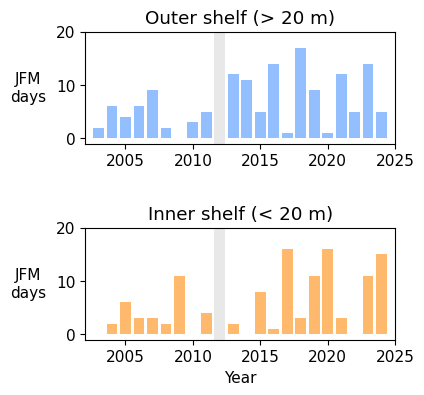

In [3736]:
fig, axs = plt.subplots(2,1, figsize=(4,4))

for ax in axs:
    ax.set_xlim(2002,2025)
    ax.set_ylim(-1,20)
    ax.set_yticks([0,10,20,])
    ax.bar(2012, 47, bottom=-2, color='lightgray', alpha=0.5)
    ax.set_ylabel('JFM\ndays', rotation=0, labelpad=20, va='center')
    
ax = axs[0]
ax.bar(years, counts['year']['flaw_open'], color = colrs['flaw_open_dark'])
ax.set_title('Outer shelf (> 20 m)')


ax = axs[1]
ax.bar(years, counts['year']['lfbo_open'], color=colrs['lfbo_open_dark'])
ax.set_title('Inner shelf (< 20 m)')
ax.set_xlabel('Year')
plt.subplots_adjust(hspace=0.75)



# x = 2026
# ax = axs[0]
# group = 'flaw_open'
# ax.scatter(x, np.nanmedian(counts['year'][group]), marker='_', zorder=2, c='k', clip_on=False)
# ax.vlines(x, np.nanpercentile(counts['year'][group], 25), 
#            np.nanpercentile(counts['year'][group], 75), linewidths=7, colors='k', zorder=0, clip_on=False)
# ax.vlines(x, np.nanpercentile(counts['year'][group], 25)+0.2, 
#            np.nanpercentile(counts['year'][group], 75)-0.2, linewidths=4, colors=flaw_color, zorder=0, clip_on=False)
# ax.vlines(x, np.nanpercentile(counts['year'][group], 5), 
#            np.nanpercentile(counts['year'][group], 95), colors='k', zorder=-1, clip_on=False)
# x = 2026
# ax = axs[1]
# group = 'lfbo_open'
# ax.scatter(x, np.nanmedian(counts['year'][group]), marker='_', zorder=2, c='k', clip_on=False)
# ax.vlines(x, np.nanpercentile(counts['year'][group], 25), 
#            np.nanpercentile(counts['year'][group], 75), linewidths=7, colors='k', zorder=0, clip_on=False)
# ax.vlines(x, np.nanpercentile(counts['year'][group], 25)+0.2, 
#            np.nanpercentile(counts['year'][group], 75)-0.2, linewidths=4, colors=lfbo_color, zorder=0, clip_on=False)
# ax.vlines(x, np.nanpercentile(counts['year'][group], 5), 
#            np.nanpercentile(counts['year'][group], 95), colors='k', zorder=-1, clip_on=False)

fig.savefig('./figures/open_event_counts_bytype.png', dpi=400, pad_inches=0, bbox_inches='tight')

In [3742]:
distinct_years[years_cond]

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

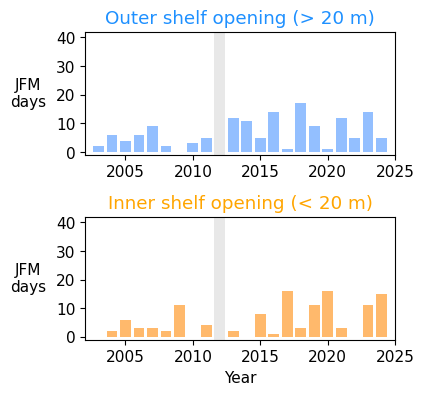

In [3792]:
fig, axs = plt.subplots(2,1, figsize=(4,4))

for ax in axs:
    ax.set_xlim(2002,2025)
    ax.set_ylim(-1,42)
    ax.set_yticks([0,10,20,30,40])
    ax.bar(2012, 47, bottom=-2, color='lightgray', alpha=0.5)
    ax.set_ylabel('JFM\ndays', rotation=0, labelpad=20, va='center')
    
ax = axs[0]
ax.bar(years, counts['year']['flaw_open'], color = colrs['flaw_open_dark'])
ax.set_title('Outer shelf opening (> 20 m)',  color = 'dodgerblue')



# x = cts['atm']['stro_se'][years_cond]
# y = counts['year']['flaw_open']
# res = stats.linregress(x, y)
# print(res)
# print(res.rvalue**2)

# ax.plot(distinct_years, cts['atm']['stro_se'], color = 'dodgerblue', marker='o')
# ax.text(0.025,0.925, 'Strong SE winds', va = 'top', ha='left', c='dodgerblue', weight='bold',  transform=ax.transAxes)
# color = [0.3,0.3,0.3]
# ax.text(1,0.9,f'R = {res.rvalue:.3f} ', ha='right', transform=ax.transAxes, size=10, c=color)
# ax.text(1,0.8,f'slope = {res.slope:.3f} ', ha='right', transform=ax.transAxes, size=10, c=color)


ax = axs[1]

ax.bar(years, counts['year']['lfbo_open'], color=colrs['lfbo_open_dark'])
ax.set_title('Inner shelf opening (< 20 m)',  color = 'orange',)
ax.set_xlabel('Year')

# x = cts['atm']['stro_sw'][years_cond]
# y = counts['year']['lfbo_open']
# res = stats.linregress(x, y)
# print(res)
# print(res.rvalue**2)
# ax.plot(distinct_years, cts['atm']['stro_sw'], color = 'orange', marker='o')
# ax.text(0.025,0.925, 'Strong SW winds', va = 'top', ha='left', c='orange', weight='bold',  transform=ax.transAxes)
# ax.text(1,0.9,f'R = {res.rvalue:.3f} ', ha='right', transform=ax.transAxes, size=10, c=color)
# ax.text(1,0.8,f'slope = {res.slope:.3f} ', ha='right', transform=ax.transAxes, size=10, c=color)

plt.subplots_adjust(hspace=0.5)



fig.savefig('./figures/open_event_counts_bytype.png', dpi=400, pad_inches=0, bbox_inches='tight')

In [ ]:
x = cts[cat]['stro_se'][years_cond]
y = counts['year']['flaw_open']
res = stats.linregress(x, y)
print(res)
print(res.rvalue**2)


ax.plot(x, y, 'o', c=flaw_color)
xvals = np.array([x.min(), x.max()])
ax.plot(xvals, res.intercept + res.slope*xvals, c='k')

ax.text(1,0.15,f'R = {res.rvalue:.3f} ', ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.05,f'slope = {res.slope:.3f} ', ha='right', transform=ax.transAxes, size=10)


R^2 = 0.134
R^2 = 0.130


Text(1, 0.85, '2.7 days/decade')

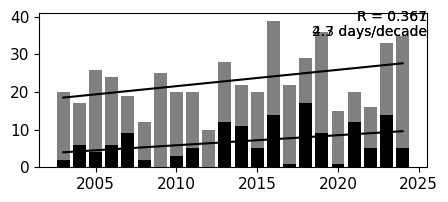

In [3319]:
fig, ax = plt.subplots(figsize=(5,2))

x = distinct_years[1:]#[years_cond] 
y = (cts['atm']['stro_sw'] + cts['atm']['stro_se'])[1:]#[years_cond]

corr = calc_correlation(x, y)
ax.bar(x, y,  color='gray')
xvals = np.array([x.min(), x.max()])
ax.plot(corr['x'], corr['y'], c='k')
ax.text(1,0.95,corr['R'], ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.85,f"{trend_per_dec(corr['res'].slope)}", ha='right', transform=ax.transAxes, size=10)





x = distinct_years[years_cond] 
y = (counts['year']['flaw_open'] )#+ counts['year']['lfbo_open'])#[years_cond]

corr = calc_correlation(x, y)
ax.bar(x, y,  color='k')
xvals = np.array([x.min(), x.max()])
ax.plot(corr['x'], corr['y'], c='k')
ax.text(1,0.95,corr['R'], ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.85,f"{trend_per_dec(corr['res'].slope)}", ha='right', transform=ax.transAxes, size=10)





<BarContainer object of 23 artists>

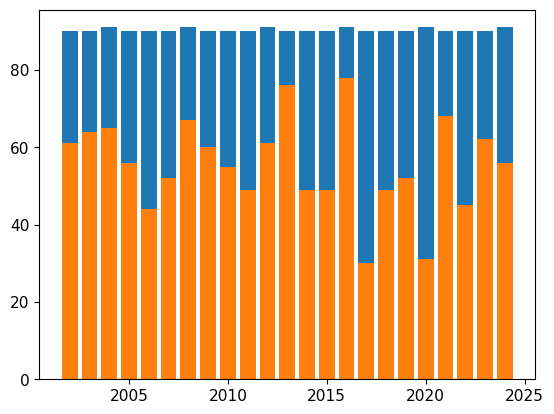

In [3329]:
plt.bar(distinct_years, cts['atm']['w'], bottom = cts['atm']['e'])
plt.bar(distinct_years, cts['atm']['e'])
# plt.plot(cts['atm']['e'])

In [3294]:
# speed_mean = np.sqrt(np.nanmean(region_ice['clim']['e'])**2+np.nanmean(region_ice['clim']['n'])**2)
# speed_mean

speed_mean = np.sqrt(np.nanmean(region_ice['clim']['e'])**2+np.nanmean(region_ice['clim']['n'])**2)


3.309951309245373

In [3310]:
np.nanmedian(region_ice['clim']['s'])

7.14473032951355

In [3311]:
np.nanmedian(region_ice['lfbo_open']['s'])

8.161815643310547

In [3312]:
np.nanmedian(region_ice['flaw_open']['s'])

8.003561019897461

In [3307]:
np.nanmean(region_ice['lfbo_open']['s'])/np.nanmean(region_ice['clim']['s'])

1.1252310462410247

In [3306]:
np.nanmean(region_ice['flaw']['s'])/np.nanmean(region_ice['clim']['s'])

1.1332336775075493

In [3301]:
np.nanmean(region_ice['lfbo']['s'])

8.453186438633846

In [3298]:
speed_mean = np.sqrt(np.nanmean(region_ice['flaw']['e'])**2+np.nanmean(region_ice['flaw']['n'])**2)
speed_mean

9.683964264616824

In [3297]:
speed_mean = np.sqrt(np.nanmean(region_ice['lfbo']['e'])**2+np.nanmean(region_ice['lfbo']['n'])**2)
speed_mean

5.143369983861569

In [3172]:
help(calc_correlation
    )

Help on function calc_correlation in module __main__:

calc_correlation(x, y)



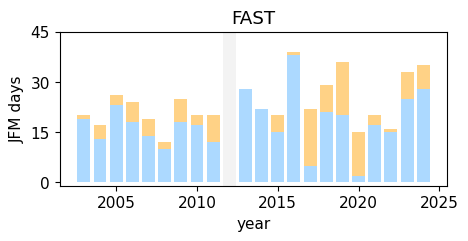

In [3171]:
fig, ax = plt.subplots(figsize=(5,2))

ax.set_ylim(-1,45)
ax.set_yticks([0,15,30,45])

ax.bar(2012, 47, bottom=-2, color='lightgray', alpha=0.25)

ax.bar(years, cts['atm']['stro_se'][years_cond], color = colrs['flaw_open'])
ax.set_title('FLAW')
ax.set_ylabel('JFM days')

ax.bar(years, cts['atm']['stro_sw'][years_cond], 
       bottom=cts['atm']['stro_se'][years_cond], color=colrs['lfbo_open'])
ax.set_title('FAST')
ax.set_ylabel('JFM days')
ax.set_xlabel('year')
plt.subplots_adjust(hspace=0.75)




[Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')]

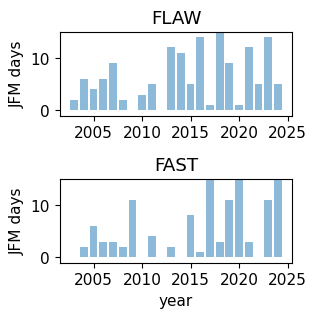

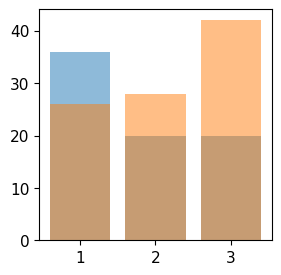

In [2781]:
fig, axs = plt.subplots(2, 1,figsize=(3,3))

for ax in axs:
    ax.set_ylim(-1,15)

ax = axs[0]
ax.bar(years, counts['year']['flaw_open'], alpha=0.5)
ax.set_title('FLAW')
ax.set_ylabel('JFM days')

ax = axs[1]
ax.bar(years, counts['year']['lfbo_open'], alpha=0.5)
ax.set_title('FAST')
ax.set_ylabel('JFM days')
ax.set_xlabel('year')
plt.subplots_adjust(hspace=0.75)

fig, ax = plt.subplots(figsize=(3,3))
plt.bar(np.arange(len(months)), counts['month']['lfbo'], alpha=0.5)
# plt.bar(np.arange(len(months)), counts['month']['lfbo'], alpha=0.5)
plt.bar(np.arange(len(months)), counts['month']['flaw'], alpha=0.5)
# plt.bar(np.arange(len(months)), counts['month']['flaw'], alpha=0.5)
ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)

# ERA5 atmospheric forcing and PP drift clim

In [2782]:
track_years = {}
track_years['lfbo_open'] = np.array([date.year for date in events['lfbo_open']['date']])
track_years['flaw_open'] = np.array([date.year for date in events['flaw_open']['date']])
track_years['lfbo'] = np.array([date.year for date in events['lfbo']['date']])
track_years['flaw'] = np.array([date.year for date in events['flaw']['date']])
track_years['clim'] = np.array([date.year for date in events['clim']['date']])

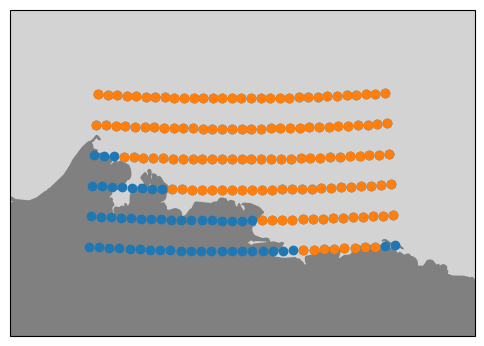

In [2662]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-153)), figsize=(6,6))
ax.set_facecolor('lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='gray'), zorder=2)
# zoom
expand = 8000
ax.set_xlim(-200000-expand,220000+expand)
ax.set_ylim(-2270000-expand,-1980000+expand)


local_lats = DSM[group]['ug'].sel(latitude=lat_local, longitude=lon_local).latitude.values
local_lons = DSM[group]['ug'].sel(latitude=lat_local, longitude=lon_local).longitude.values

longrid, latgrid = np.meshgrid(local_lons, local_lats)
ax.scatter(longrid, latgrid, transform=ccrs.PlateCarree(), zorder=100)

include = np.full(longrid.shape, True)
include[5,:-10] = False
include[5,-2:] = False
include[4,:-14] = False
include[3,:-23] = False
include[2,:-28] = False

ax.scatter(longrid[include], latgrid[include], 
           transform=ccrs.PlateCarree(), zorder=100)




In [3047]:
DSM = {}
GSM = {}

# list of distinct years
key = 'clim'
# distinct_years = np.array(list(set(track_years[key])))
# distinct_years = np.arange(1979,2025)
distinct_years = np.arange(2002,2025)

for ii in range(len(distinct_years)):
    
    year = distinct_years[ii]
    print(year)
    
    lat_slice = slice(90,60)
#     lon_slice = slice(-180,-100)
#     lon_slice = np.append(np.arange(150,180, 0.25), np.arange(-180,-90, 0.25))
    
#     lat_slice = slice(75,68)
#     lon_slice = np.arange(-170,-140, 0.25)

#     lat_slice = slice(75,68)
#     lon_slice = np.arange(-170,-140, 0.25)

    date_slice = slice(datetime(year, 1, 1), datetime(year, 3, 31))
    
    # open surface variables
    DS = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    DS.close()
    DSalt = DS.sel(time = date_slice, latitude=lat_slice)#, longitude=lon_slice)
    
    
    # save geostrophic wind components too
    DS2 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/dailyJFM_pressure/JFM_pressure_{year}.nc')
    DS2.close()
    crop_DS = DS2.sel(pressure_level = 1000).z.sel(latitude=lat_slice)#, longitude=lon_slice)
    crop_DS = crop_DS.rename({'valid_time': 'time'})
    (DSalt['ug'],DSalt['vg']) = metpy.calc.geostrophic_wind(crop_DS.drop_vars(['number','pressure_level']))
    
    if ii == 0:
        DSM[key] = DSalt
    else:
        DSM[key] = xr.merge([DSM[key], DSalt])
    

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


### subset spec. conditions

In [3048]:
key = 'clim'
longrid, latgrid = np.meshgrid(DSM[key].longitude, DSM[key].latitude)
longrid[longrid<0]+=360
DSM['flaw'] = DSM['clim'].sel(time=events['flaw']['date'])
DSM['lfbo'] = DSM['clim'].sel(time=events['lfbo']['date'])

DSM['flaw_open'] = DSM['clim'].sel(time=events['flaw_open']['date'])
DSM['lfbo_open'] = DSM['clim'].sel(time=events['lfbo_open']['date'])

atm = {}

atm['clim'] = {}
atm['flaw'] = {}
atm['lfbo'] = {}
atm['flaw_open'] = {}
atm['lfbo_open'] = {}

for group in atm.keys():
    mean_o_speed = np.sqrt(DSM[group].u10**2 + DSM[group].v10**2).mean(dim='time')
    speed_o_mean = np.sqrt(DSM[group].u10.mean(dim='time')**2 + DSM[group].v10.mean(dim='time')**2)
    atm[group]['dc'] = speed_o_mean / mean_o_speed
    
    msl_diff = (DSM[group].msl - DSM[group].msl.sel(latitude=71, longitude = -153))/100
    atm[group]['mslgrad'] = msl_diff
    
    
    atm[group]['vort'] = metpy.calc.vorticity(DSM[group].u10.mean(dim='time') * units('m/s'), 
                                              DSM[group].v10.mean(dim='time') * units('m/s'))
    

In [3049]:
lat_local = slice(71.85, 70.35)
lon_local = slice(-156.5, -149)

# lat_slice = slice(72.5, 70.35)
# lon_slice = slice(-165, -140)

region_atm = {}
for group in DSM.keys():
    region_atm[group] = {}

    region_atm[group]['ug'] = np.array([])
    region_atm[group]['vg'] = np.array([])
    
    for ii in range(len(DSM[group]['ug'])):
        meanval = np.mean(DSM[group]['ug'].sel(latitude=lat_local, longitude=lon_local).values[ii][include])
        region_atm[group]['ug'] = np.append(region_atm[group]['ug'], meanval)
        
        meanval = np.mean(DSM[group]['vg'].sel(latitude=lat_local, longitude=lon_local).values[ii][include])
        region_atm[group]['vg'] = np.append(region_atm[group]['vg'], meanval)
        
#     region_atm[group]['ug'] = DSM[group]['ug'].sel(latitude=lat_local, longitude=lon_local).mean(dim=['longitude', 'latitude'])
#     region_atm[group]['vg'] = DSM[group]['vg'].sel(latitude=lat_local, longitude=lon_local).mean(dim=['longitude', 'latitude'])
    
    region_atm[group]['u10'] = DSM[group]['u10'].sel(latitude=lat_local, longitude=lon_local).mean(dim=['longitude', 'latitude'])
    region_atm[group]['v10'] = DSM[group]['v10'].sel(latitude=lat_local, longitude=lon_local).mean(dim=['longitude', 'latitude'])
    region_atm[group]['msl'] = DSM[group]['msl'].sel(latitude=lat_local, longitude=lon_local).mean(dim=['longitude', 'latitude'])/100

    

## Ice drift

In [ ]:

OSM = {}

# list of distinct years
key = 'clim'
distinct_years = np.array(list(set(track_years[key])))

for ii in range(len(distinct_years)):
    
    year = distinct_years[ii]
    print(year)
    
    DS = xr.open_dataset(f'/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/icemotion_daily_nh_25km_{year}0101_{year}1231_v4.1.nc')
    DS = DS.convert_calendar('standard')
    DS.close()
    
    xslice = slice(-2000000,1000000)
    yslice = slice(-1000000,2500000)
    
    if ii == 0:
        OSM[key] = DS.sel(time = events[key]['date'][track_years[key] == year])#, x=xslice, y=yslice)
    else:
        DS = DS.sel(time = events[key]['date'][track_years[key] == year])#, x=xslice, y=yslice)
        OSM[key] = xr.merge([OSM[key], DS])

### Subset spec. conditions

In [230]:
# ICE DIRFT
E, N = PPdrift.convert_vectors(lon=OSM['clim'].longitude, u_EASE=OSM['clim'].u, v_EASE=OSM['clim'].v)
OSM['clim']['e'] = (('time','y', 'x'), E.data)
OSM['clim']['n'] = (('time','y', 'x'), N.data)

OSM['flaw'] = OSM['clim'].sel(time=events['flaw']['date'])
OSM['lfbo'] = OSM['clim'].sel(time=events['lfbo']['date'])

OSM['flaw_open'] = OSM['clim'].sel(time=events['flaw_open']['date'])
OSM['lfbo_open'] = OSM['clim'].sel(time=events['lfbo_open']['date'])

In [ ]:
# drift    
drift_lats = np.copy(OSM['clim'].latitude[:,:,0])
drift_lons = np.copy(OSM['clim'].longitude[:,:,0])
drift_lons[drift_lons>180] -= 360

drift_lat_range = (drift_lats > poly_lats.min()) & (drift_lats < poly_lats.max())
drift_range = ((drift_lons > poly_lons.min()) & (drift_lons < poly_lons.max()))&drift_lat_range


region_ice = {}
region_ice['clim'] = {}
region_ice['flaw'] = {}
region_ice['lfbo'] = {}
region_ice['flaw_open'] = {}
region_ice['lfbo_open'] = {}

for key in region_ice.keys():
    
    region_ice[key]['e'] = np.array([])
    region_ice[key]['n'] = np.array([])
    region_ice[key]['s'] = np.array([])
    
    for tt in range(len(OSM[key].time)):
        
        region_ice[key]['e'] = np.append(region_ice[key]['e'], np.nanmean(OSM[key].e[tt].values[drift_range]))
        region_ice[key]['n'] = np.append(region_ice[key]['n'], np.nanmean(OSM[key].n[tt].values[drift_range]))
        
        speed = np.sqrt(OSM[key].u[tt].values**2 + OSM[key].v[tt].values**2)
        region_ice[key]['s'] = np.append(region_ice[key]['s'], np.nanmean(speed))
        

## Wind conditions

In [2785]:
clim_directions = np.arctan2(region_atm['clim']['vg'], region_atm['clim']['ug']) * 180/np.pi
clim_speed = np.sqrt(region_atm['clim']['vg']**2 + region_atm['clim']['ug']**2)


# mid_point_bins = np.arange(-180,180,15)
# bin_width = np.diff(mid_point_bins)[0]
# direction_bins = mid_point_bins + bin_width/2

direction_bins = np.arange(-180,181,15)
dir_bin_width = np.diff(direction_bins)[0]
mid_point_bins = direction_bins[:-1] + dir_bin_width/2
direction_counts = np.zeros(len(mid_point_bins))

print(mid_point_bins)
print(direction_bins)

speed_bins = {}
speed_bins['mean'] = np.zeros(len(mid_point_bins))
speed_bins['mean_mstd'] = np.zeros(len(mid_point_bins))
speed_bins['mean_mstd_half'] = np.zeros(len(mid_point_bins))
speed_bins['mean_pstd'] = np.zeros(len(mid_point_bins))
speed_bins['mean_pstd_half'] = np.zeros(len(mid_point_bins))
speed_bins['25th'] = np.zeros(len(mid_point_bins))
speed_bins['75th'] = np.zeros(len(mid_point_bins))
speed_bins['median'] = np.zeros(len(mid_point_bins))

for ii in range(len(mid_point_bins)):
        
    if ii == 0:
        dir2 = mid_point_bins[ii] + dir_bin_width/2
        dir1 = mid_point_bins[ii] - dir_bin_width/2
        within_bin = (clim_directions>dir1) & (clim_directions<=dir2)#(clim_directions>dir1).astype(int) + (clim_directions<=dir2).astype(int) > 0
        
    else:
        dir2 = mid_point_bins[ii] + dir_bin_width/2
        dir1 = mid_point_bins[ii] - dir_bin_width/2
        within_bin = (clim_directions>dir1) & (clim_directions<=dir2)
    
    direction_counts[ii] = np.sum( within_bin )
    speed_bins['mean'][ii] = np.nanmean(clim_speed[within_bin])
    speed_bins['mean_pstd'][ii] = np.nanmean(clim_speed[within_bin])+np.nanstd(clim_speed[within_bin])
    speed_bins['mean_mstd'][ii] = np.nanmean(clim_speed[within_bin])-np.nanstd(clim_speed[within_bin])
    speed_bins['mean_pstd_half'][ii] = np.nanmean(clim_speed[within_bin])+0.5*np.nanstd(clim_speed[within_bin])
    speed_bins['mean_mstd_half'][ii] = np.nanmean(clim_speed[within_bin])-0.5*np.nanstd(clim_speed[within_bin])
    speed_bins['median'][ii] = np.nanmedian(clim_speed[within_bin])
    speed_bins['25th'][ii] = np.nanpercentile(clim_speed[within_bin], 25)
    speed_bins['75th'][ii] = np.nanpercentile(clim_speed[within_bin], 75)
    
    
speed_comps = {}
for cat in speed_bins.keys():
    speed_comps[f'{cat}_x'] = speed_bins[cat]*np.cos(mid_point_bins*np.pi/180)
    speed_comps[f'{cat}_y'] = speed_bins[cat]*np.sin(mid_point_bins*np.pi/180)

    speed_comps[f'{cat}_x'] = np.append(speed_comps[f'{cat}_x'], speed_comps[f'{cat}_x'][0])
    speed_comps[f'{cat}_y'] = np.append(speed_comps[f'{cat}_y'], speed_comps[f'{cat}_y'][0])

[-172.5 -157.5 -142.5 -127.5 -112.5  -97.5  -82.5  -67.5  -52.5  -37.5
  -22.5   -7.5    7.5   22.5   37.5   52.5   67.5   82.5   97.5  112.5
  127.5  142.5  157.5  172.5]
[-180 -165 -150 -135 -120 -105  -90  -75  -60  -45  -30  -15    0   15
   30   45   60   75   90  105  120  135  150  165  180]


In [2786]:
def plot_arrow(theta, r, offset=5, length=5, color='k'):
    
    
    ax.plot([theta, theta], [0, r], 
                    alpha = 1, color = 'k', lw = 3, zorder = 5)
    ax.plot([theta, theta-offset*np.pi/180], [r, r-length], 
                    alpha = 1, color = 'k', lw = 3, zorder = 5)
    ax.plot([theta, theta+offset*np.pi/180], [r, r-length], 
                    alpha = 1, color = 'k', lw = 3, zorder = 5)
    
    
    ax.plot([theta, theta], [0, r], 
                    alpha = 1, color = color, lw = 1.5, zorder = 5)
    ax.plot([theta, theta-offset*np.pi/180], [r, r-length], 
                    alpha = 1, color = color, lw = 1.5, zorder = 5)
    ax.plot([theta, theta+offset*np.pi/180], [r, r-length], 
                    alpha = 1, color = color, lw = 1.5, zorder = 5)

[-3.11076993 -2.07559922 -1.88544723 ... -2.82607008  2.75522526
 -3.05691116]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3213/3688427088.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(theta, r, s=5,


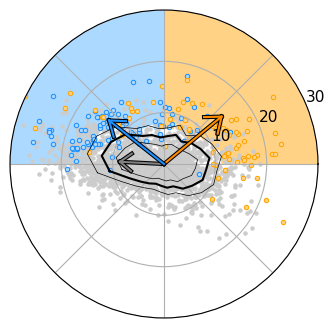

In [3512]:

fig = plt.figure(figsize = (4,4))
ax = plt.subplot(111, polar=True)
ax.set_rlim(0,30)
ax.set_rticks([10,20,30])
ax.set_xticklabels([])


group = 'clim'
theta = np.arctan2(region_atm[group]['vg'], region_atm[group]['ug'])
print(theta)
theta[theta<0]+=2*np.pi
r = np.sqrt(region_atm[group]['vg']**2+region_atm[group]['ug']**2)
plt.scatter(theta, r, s=5, 
            c=[0.8,0.8,0.8])



# clim speeds
theta = mid_point_bins * np.pi/180
width = 2*np.pi / len(mid_point_bins)
r = speed_bins['mean']
# bars = ax.bar(theta, r, width=width,bottom=0,color='darkgray', edgecolor="gray")

theta = np.append(theta, theta[0])
r = np.append(r, r[0])
ax.plot(theta, r, c='k')

r = speed_bins['mean_pstd_half']
r = np.append(r, r[0])
ax.plot(theta, r, c='k', lw=0.5)

cond = (mid_point_bins >= 7.5)&(mid_point_bins <= 82.5)
bars = ax.bar(theta[:-1][cond], 30-r[:-1][cond], 
              width=width,bottom=r[:-1][cond],color=lfbo_color, edgecolor=lfbo_color, zorder=-5)

cond = (mid_point_bins > 82.5)&(mid_point_bins <= 172.5)
bars = ax.bar(theta[:-1][cond], 30-r[:-1][cond], 
              width=width,bottom=r[:-1][cond],color=flaw_color, edgecolor=flaw_color, zorder=-5)


r = speed_bins['mean_mstd_half']
r = np.append(r, r[0])
ax.plot(theta, r, c='k', lw=0.5)
# for th, R in zip(theta, r):
#     ax.plot([th, th], [0,R], c='k')


group = 'clim'
theta_mean = np.arctan2(np.nanmean(region_atm[group]['vg']), np.nanmean(region_atm[group]['ug']))
R = np.nanmean(np.sqrt(region_atm[group]['vg']**2+region_atm[group]['ug']**2))
plot_arrow(theta_mean, R, offset=15, length=2, color='gray')


group = 'lfbo'
theta_mean = np.arctan2(np.nanmean(region_atm[group]['vg']), np.nanmean(region_atm[group]['ug']))
R = np.nanmean(np.sqrt(region_atm[group]['vg']**2+region_atm[group]['ug']**2))
plot_arrow(theta_mean, R, offset=10, length=2.5, color='darkorange')

group = 'flaw'
theta_mean = np.arctan2(np.nanmean(region_atm[group]['vg']), np.nanmean(region_atm[group]['ug']))
R = np.nanmean(np.sqrt(region_atm[group]['vg']**2+region_atm[group]['ug']**2))
plot_arrow(theta_mean, R, offset=10, length=2.5, color='dodgerblue')



# arrow at 45 degree
# arr2 = plt.arrow(THETA, 0, 0, R, alpha = 0.5, 
#                  width=0.05,length_includes_head=True,edgecolor = 'black', 
#                  facecolor = 'green', lw = 2, zorder = 5)

# th1 = 82.5*np.pi/180
# ax.plot([th1,th1], [0,30],  c='k')

# th1 = 172.5*np.pi/180
# ax.plot([th1,th1], [0,30],  c='k')

# th1 = -7.5*np.pi/180
# ax.plot([th1,th1], [0,30],  c='k')


# th1 = 75*np.pi/180
# ax.plot([th1,th1], [0,30],  c='k')

# th1 = 165*np.pi/180
# ax.plot([th1,th1], [0,30],  c='k')

# th1 = -15*np.pi/180
# ax.plot([th1,th1], [0,30],  c='k')

# r = speed_bins['mean']
# width = 2*np.pi / len(mid_point_bins)
# bars = ax.bar(theta, r, width=width,bottom=0,color='gray', edgecolor="gray")


group = 'flaw'
thresh = events[group]['area'] > 0
theta = np.arctan2(region_atm[group]['vg'][thresh], region_atm[group]['ug'][thresh])
theta[theta<0]+=2*np.pi
r = np.sqrt(region_atm[group]['vg'][thresh]**2+region_atm[group]['ug'][thresh]**2)
plt.scatter(theta, r, 
            s = 10,#events[group]['area'][thresh]/30, 
            color=flaw_color, edgecolor='dodgerblue', lw=0.75)


group = 'lfbo'
thresh = events[group]['area'] > 0
theta = np.arctan2(region_atm[group]['vg'][thresh], region_atm[group]['ug'][thresh])
theta[theta<0]+=2*np.pi
r = np.sqrt(region_atm[group]['vg'][thresh]**2+region_atm[group]['ug'][thresh]**2)
plt.scatter(theta, r, 
            s = 10,#events[group]['area'][thresh]/30, 
            color=lfbo_color, edgecolor='orange', lw=0.75)



fig.savefig('./figures/wind_directions.png', dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)


In [2760]:
82.5-15

67.5

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3213/2065781487.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(region_atm[group]['ug'][thresh], region_atm[group]['vg'][thresh],
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3213/2065781487.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(region_atm[group]['ug'][thresh], region_atm[group]['vg'][thresh],


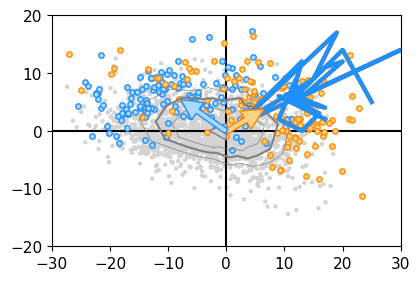

In [3439]:


fig, ax = plt.subplots(figsize=(1.5*3,1.5*2))
ax.set_ylim(-20,20)
ax.set_xlim(-30,30)

group = 'clim'
plt.scatter(region_atm[group]['ug'], region_atm[group]['vg'], s = 10, c='lightgray', edgecolor='None', zorder=-1)
# ax.scatter(x, y, c=z, s=3, cmap='Blues', zorder=-2)
plt.axhline(0, c='k', zorder=-1)
plt.axvline(0, c='k', zorder=-1)

# speed = 8
# ax.plot(speed*np.sin(np.linspace(0,2*pi)), speed*np.cos(np.linspace(0,2*pi)))


group = 'flaw_open'
thresh = events[group]['area'] > 0
plt.scatter(region_atm[group]['ug'][thresh], region_atm[group]['vg'][thresh], 
            s = 15,#events[group]['area'][thresh]/30, 
            c=flaw_color, edgecolor='dodgerblue')

group = 'lfbo_open'
thresh = events[group]['area'] > 0
plt.scatter(region_atm[group]['ug'][thresh], region_atm[group]['vg'][thresh], 
            s = 15,#events[group]['area'][thresh]/30, 
            c=lfbo_color, edgecolor='darkorange')


arrow_kwargs = {'angles':'xy', 'scale_units' : 'xy', 'scale':1, 'width':0.015, 
                'headwidth':4, 'headlength':4, 'headaxislength':4, 'zorder':3}
cat = 'clim'
ax.quiver(0,0,
           np.mean(region_atm[cat]['ug']), 
           np.mean(region_atm[cat]['vg']), 
           color='lightgray', edgecolor='gray', lw=1, **arrow_kwargs)
# x,y = create_SDellipses(region_atm[cat]['ug'], region_atm[cat]['vg'])
plt.plot(x,y, c='gray', lw=3) 

cat = 'lfbo_open'
ax.quiver(0,0,
           np.mean(region_atm[cat]['ug']), 
           np.mean(region_atm[cat]['vg']), 
           color=lfbo_color, edgecolor='darkorange', lw=1, **arrow_kwargs)
# x,y = create_SDellipses(region_atm[cat]['ug'], region_atm[cat]['vg'])
plt.plot(x,y, c='darkorange', lw=3) 

cat = 'flaw_open'
ax.quiver(0,0,
           np.mean(region_atm[cat]['ug']), 
           np.mean(region_atm[cat]['vg']), 
           color=flaw_color, edgecolor='dodgerblue', lw=1, **arrow_kwargs)
# x,y = create_SDellipses(region_atm[cat]['ug'], region_atm[cat]['vg'])
plt.plot(x,y, c='dodgerblue', lw=3) 


# # x,y = create_SDellipses(region_atm['clim']['u10'].values,region_atm['clim']['v10'].values)
# # plt.plot(x,y, c='gray' ) 

plt.plot(speed_comps['mean_x'], speed_comps['mean_y'], c='gray',)
plt.plot(speed_comps['mean_mstd_half_x'], speed_comps['mean_mstd_half_y'], c='gray', lw=0.5)
plt.plot(speed_comps['mean_pstd_half_x'], speed_comps['mean_pstd_half_y'], c='gray', lw=0.5)

# # plt.plot(speed_comps['median_x'], speed_comps['median_y'], c='k')
# # plt.plot(speed_comps['75th_x'], speed_comps['75th_y'], c='k', lw=0.5)
# # plt.plot(speed_comps['25th_x'], speed_comps['25th_y'], c='k', lw=0.5)


# arrow_kwargs = {'angles':'xy', 'scale_units' : 'xy', 'scale':1, 'width':0.01, 'headwidth':5, 'zorder':3}
# cat = 'lfbo_open'
# ax.quiver(0,0,
#            np.mean(region_atm[cat]['ug']), 
#            np.mean(region_atm[cat]['vg']), 
#            color=[1,0.8,0.5], edgecolor='darkorange', lw=0.5, **arrow_kwargs)
# cat = 'flaw_open'
# ax.quiver(0,0,
#            np.mean(region_atm[cat]['ug']), 
#            np.mean(region_atm[cat]['vg']), 
#            color='dodgerblue', **arrow_kwargs)
# cat = 'clim'
# ax.quiver(0,0,
#            np.mean(region_atm[cat]['ug']), 
#            np.mean(region_atm[cat]['vg']), 
#            color='gray', **arrow_kwargs)



# # mean_speed = np.mean(np.sqrt(region_atm['clim']['u10']**2+(region_atm['clim']['v10']**2)))
# # speed_of_mean = np.sqrt(np.mean(region_atm['clim']['u10'])**2 + np.mean(region_atm['clim']['v10'])**2)
# # ax.quiver(0,0,
# #            mean_speed*np.mean(region_atm['clim']['u10'])/speed_of_mean, 
# #            mean_speed*np.mean(region_atm['clim']['v10'])/speed_of_mean, 
# #            color='gray', **arrow_kwargs)
# # cat = 'flaw'
# # mean_speed = np.mean(np.sqrt(region_atm[cat]['u10']**2+(region_atm[cat]['v10']**2)))
# # speed_of_mean = np.sqrt(np.mean(region_atm[cat]['u10'])**2 + np.mean(region_atm[cat]['v10'])**2)
# # ax.quiver(0,0,
# #            mean_speed*np.mean(region_atm[cat]['u10'])/speed_of_mean, 
# #            mean_speed*np.mean(region_atm[cat]['v10'])/speed_of_mean, 
# #            color='dodgerblue', **arrow_kwargs)

# # cat = 'lfbo'
# # mean_speed = np.mean(np.sqrt(region_atm[cat]['u10']**2+(region_atm[cat]['v10']**2)))
# # speed_of_mean = np.sqrt(np.mean(region_atm[cat]['u10'])**2 + np.mean(region_atm[cat]['v10'])**2)
# # ax.quiver(0,0,
# #            mean_speed*np.mean(region_atm[cat]['u10'])/speed_of_mean, 
# #            mean_speed*np.mean(region_atm[cat]['v10'])/speed_of_mean, 
# #            color='lightcoral', **arrow_kwargs)


### atm variance ellipses / hists

In [3599]:
import matplotlib.patches as patches

from matplotlib.patches import Wedge, Rectangle

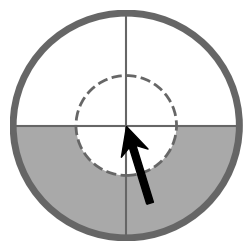

In [3675]:
fig, ax = plt.subplots(figsize=(3,3,))

size1 = 18
buff=0.5
ax.set_ylim(-size1-buff,size1+buff)
ax.set_xlim(-size1-buff,size1+buff)

ax.set_yticks([])
ax.set_xticks([])
for spine in ax.spines:
    ax.spines[spine].set_linewidth(0)


linecolor = [0.4,0.4,0.4]
    
circle1 = plt.Circle((0, 0), size1, facecolor='white', edgecolor='k', lw=0, zorder=0)
circle4 = plt.Circle((0, 0), size1, facecolor='None', edgecolor=linecolor, lw=5, zorder=100)
circle2 = plt.Circle((0, 0), 8, facecolor='white', edgecolor='k', lw=0, linestyle='solid', zorder=4)
circle3 = plt.Circle((0, 0), 8, facecolor='None', edgecolor=linecolor, lw=2, linestyle='dashed', zorder=6)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle4)

# rectTR = patches.Rectangle((0,0), size1,size1, linewidth=2, edgecolor='None', facecolor='white', zorder=1)
# rectTL = patches.Rectangle((0,0), -size1,size1, linewidth=2, edgecolor='None', facecolor='white', zorder=1)



ax.plot([0,0], [-size1,size1], c=linecolor, zorder=100)
ax.plot([-size1,size1], [0,0], c=linecolor, zorder=100)



arrow_kwargs = {'angles':'xy', 'scale_units' : 'xy', 'scale':1, 'width':0.03,
                'headlength':4, 'headaxislength':3, 'headwidth':4, 'zorder':101, 'pivot':'tip'}


# events_u = region_atm['clim']['ug']
# events_v = region_atm['clim']['vg']
# point_c = 'lightgray'
# c = 'gray'

events_u = np.append(region_atm['lfbo_open']['ug'], region_atm['flaw_open']['ug'])
events_v = np.append(region_atm['lfbo_open']['vg'], region_atm['flaw_open']['vg'])
point_c = 'k'
c = 'k'

theta1, theta2 = 180, 360
radius = size1
center = (0, 0)
w = Wedge(center, radius, theta1, theta2, fc='darkgray', edgecolor='None', zorder=3)
ax.add_patch(w)


# events_u = region_atm['lfbo_open']['ug']
# events_v = region_atm['lfbo_open']['vg']
# point_c = lfbo_color
# c = 'k'

# theta1, theta2 = 180, 270
# radius = size1
# center = (0, 0)
# w = Wedge(center, radius, theta1, theta2, fc='orange', edgecolor='None', zorder=3)
# ax.add_patch(w)


# events_u = region_atm['flaw_open']['ug']
# events_v = region_atm['flaw_open']['vg']
# point_c = flaw_color
# c = 'k'

# theta1, theta2 = 270, 360
# radius = size1
# center = (0, 0)
# w = Wedge(center, radius, theta1, theta2, fc='dodgerblue', edgecolor='None', zorder=3)
# ax.add_patch(w)

speed = np.sqrt(events_u**2+events_v**2)
mean_speed = np.mean(np.sqrt(events_u**2+events_v**2))
speed_mean = np.sqrt(np.mean(events_u)**2+np.mean(events_v)**2)
norm_u = mean_speed*np.mean(events_u)/speed_mean
norm_v = mean_speed*np.mean(events_v)/speed_mean
ax.quiver(0,0,
           norm_u, 
           norm_v, 
           color=c, edgecolor='k',lw=1,  **arrow_kwargs)


# ax.add_patch(rectTR)
# ax.add_patch(rectTL)

# ax.scatter(-events_u[speed<size1-1], -events_v[speed<size1-1], 
#            c=point_c,  s=20, edgecolor='gray', lw=0.25, zorder=5)
# ax.scatter(-events_u, -events_v, 
#            c=point_c,  s=20, edgecolor='gray', lw=0.25, zorder=5)






fig.savefig('./figures/ellipses_wind.png', dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)


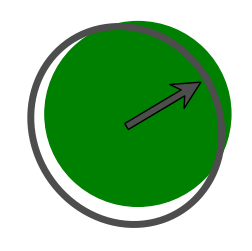

In [3526]:

arrow_kwargs = {'angles':'xy', 'scale_units' : 'xy', 'scale':1, 'width':0.03,
                'headlength':4, 'headaxislength':3, 'headwidth':4, 'zorder':3, 'pivot':'tail'}



# ax.quiver(0,0,
#            np.mean(region_atm['clim']['ug']), 
#            np.mean(region_atm['clim']['vg']), 
#            color='lightgray',edgecolor='gray',lw=1, **arrow_kwargs)
# x,y = create_SDellipses(region_atm['clim']['ug'],region_atm['clim']['vg'])
# plt.plot(x,y+0, c='lightgray', lw=5 ) 


cat = 'lfbo_open'
c = [0.3,0.3,0.3]#lfbo_color
ax.quiver(0,0,
           np.mean(region_atm[cat]['ug']), 
           np.mean(region_atm[cat]['vg']), 
           color=c, edgecolor='k',lw=1,  **arrow_kwargs)
x,y = create_SDellipses(region_atm[cat]['ug'],region_atm[cat]['vg'])
plt.plot(x,y+0, c=c, lw=5 ) 


# ax.quiver(0,0,
#            np.mean(region_ice['clim']['e']), 
#            np.mean(region_ice['clim']['n']), 
#            color='lightgray',edgecolor='gray',lw=1, **arrow_kwargs)
# x,y = create_SDellipses(region_ice['clim']['e'],region_ice['clim']['n'])
# plt.plot(x,y+0, c='lightgray', lw=5 ) 

# c = [0.3,0.3,0.3]#lfbo_color
# ax.quiver(0,0,
#            np.mean(region_ice[cat]['e']), 
#            np.mean(region_ice[cat]['n']), 
#            color=c, edgecolor='k',lw=1,  **arrow_kwargs)
# x,y = create_SDellipses(region_ice[cat]['e'],region_ice[cat]['n'])
# plt.plot(x,y+0, c=c, lw=5 ) 

# cat = 'flaw_open'
# ax.quiver(0,0,
#            np.mean(region_atm[cat]['ug']), 
#            np.mean(region_atm[cat]['vg']), 
#            color=flaw_color, edgecolor='dodgerblue',lw=1, **arrow_kwargs )
# x,y = create_SDellipses(region_atm[cat]['ug'],region_atm[cat]['vg'])
# plt.plot(x,y+0, c=flaw_color ) 


fig.savefig('./figures/ellipses_wind.png', dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)

# fig, axs = plt.subplots(3,1, figsize=(2,3))

# bins = np.arange(-25,26,2)
# # bins = np.arange(980,1060,4)


# var = 'ug'

# cat = 'clim'
# ax = axs[0]
# variable = region_atm[cat][var]
# ax.hist(variable, bins = bins, alpha=0.5, color='gray', density=True)
# ax.axvline(np.nanmean(variable), color='k')
# ax.text(1,1, f'{np.nanmean(variable):.1f}', color='k', ha='right', va='top', transform=ax.transAxes)
# ax.axvline(np.nanmean(variable)-np.nanstd(variable), lw=0.5, color='k')
# ax.axvline(np.nanmean(variable)+np.nanstd(variable), lw=0.5, color='k')


# cat = 'lfbo_open'
# ax = axs[1]
# thresh = events[cat]['area'] > np.nanpercentile(events[cat]['area'], 0)
# variable = region_atm[cat][var][thresh]
# ax.hist(variable, bins = bins, alpha=0.5, color='orange', density=True)
# ax.axvline(np.nanmean(variable), color='k')
# ax.text(1,1, f'{np.nanmean(variable):.1f}', color='k', ha='right', va='top', transform=ax.transAxes)
# ax.axvline(np.nanmean(variable)-np.nanstd(variable), lw=0.5, color='k')
# ax.axvline(np.nanmean(variable)+np.nanstd(variable), lw=0.5, color='k')

# cat = 'flaw_open'
# ax = axs[2]
# thresh = events[cat]['area'] > np.nanpercentile(events[cat]['area'], 0)
# variable = region_atm[cat][var][thresh]
# ax.hist(variable, bins = bins, alpha=0.5, color='dodgerblue', density=True)
# ax.axvline(np.nanmean(variable), color='k')
# ax.text(1,1, f'{np.nanmean(variable):.1f}', color='k', ha='right', va='top', transform=ax.transAxes)
# ax.axvline(np.nanmean(variable)-np.nanstd(variable), lw=0.5, color='k')
# ax.axvline(np.nanmean(variable)+np.nanstd(variable), lw=0.5, color='k')

In [2671]:
50/30

1.6666666666666667

In [2672]:
3*1.666

4.997999999999999

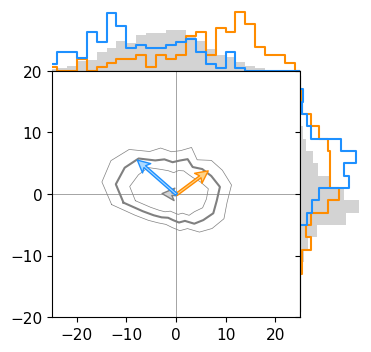

In [3724]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize= (4,4))
# fig.suptitle("Local winds")

gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])
axt = fig.add_subplot(gs[0])
axi = fig.add_subplot(gs[1])
axM = fig.add_subplot(gs[2])
axr = fig.add_subplot(gs[3])
axi.set_visible(False)
plt.subplots_adjust(hspace=0.0, wspace=0.0)


for ax in [axt, axM]:
    ax.set_xlim(-25,25)
    ax.set_xticks([-20,-10,0,10,20])
axt.set_xticklabels([])
axt.set_yticks([])

for spine in ['top', 'left', 'right']:
    axt.spines[spine].set_visible(False)

for ax in [axr, axM]:
    ax.set_ylim(-15,15)
    ax.set_yticks([-20,-10,0,10,20])
axr.set_yticklabels([])
axr.set_xticks([])
for spine in ['top', 'bottom', 'right']:
    axr.spines[spine].set_visible(False)
    

cats = ['clim', 'lfbo_open', 'flaw_open']
facecolors = ['lightgray', lfbo_color, flaw_color]
alphas = [1,0,0]
edgecolors = ['gray', 'darkorange', 'dodgerblue']


ax = axM
ax.axhline(0,c='gray', lw=0.5, zorder=-1)
ax.axvline(0,c='gray', lw=0.5, zorder=-1)
# ax.axhline(10,c='gray', lw=0.5, zorder=-1)
# ax.axvline(10,c='gray', lw=0.5, zorder=-1)
arrow_kwargs = {'angles':'xy', 'scale_units' : 'xy', 'scale':1, 'width':0.01,
                'headlength':5, 'headaxislength':4, 'headwidth':5, 'zorder':3}



for cat, face, edge, alpha in zip(cats, facecolors, edgecolors, alphas):

    if cat == 'clim':
        edge='gray'
    ax.quiver(0,0,
               np.mean(region_atm[cat]['ug']), 
               np.mean(region_atm[cat]['vg']), 
               color=face,edgecolor=edge,lw=1, **arrow_kwargs)
#     x,y = create_SDellipses(region_atm[cat]['ug'],region_atm[cat]['vg'])
#     ax.plot(x,y, c=face ) 


ax.plot(speed_comps['mean_x'], speed_comps['mean_y'], c='gray',)
ax.plot(speed_comps['mean_mstd_half_x'], speed_comps['mean_mstd_half_y'], c='gray', lw=0.5)
ax.plot(speed_comps['mean_pstd_half_x'], speed_comps['mean_pstd_half_y'], c='gray', lw=0.5)





ax = axt
var = 'ug'
bins = np.arange(-30,31,2)
bin_width = np.diff(bins)[0]
bin_centers = bins[:-1] + bin_width/2


for cat, face, edge, alpha in zip(cats, facecolors, edgecolors, alphas):
    
    if cat == 'clim':
        edge='None'
        
    bincounts, edges = np.histogram(region_atm[cat][var], bins = bins, density=True)
    ax.bar(bin_centers, bincounts, width= bin_width,facecolor=face, alpha=alpha)
    ax.step(bins[:-1], bincounts, alpha=1, c=edge, where='post')

ax = axr
var = 'vg'
bins = np.arange(-20,21,2)
bin_width = np.diff(bins)[0]
bin_centers = bins[:-1] + bin_width/2

for cat, face, edge, alpha in zip(cats, facecolors, edgecolors, alphas):
    
    if cat == 'clim':
        edge='None'
        
    bincounts, edges = np.histogram(region_atm[cat][var], bins = bins, density=True)
    ax.barh(bins[:-1], bincounts, height=  bin_width, facecolor=face, alpha=alpha)
    ax.step(bincounts, bin_centers, alpha=1, c=edge, where='post')


In [2674]:
len(counts)

2

### drift variance ellipses / hists

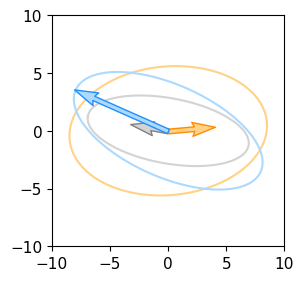

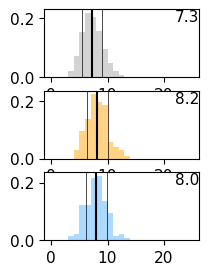

In [3115]:
fig, ax = plt.subplots(figsize=(3,3,))
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)

arrow_kwargs = {'angles':'xy', 'scale_units' : 'xy', 'scale':1, 'width':0.02, 'zorder':3}

ax.quiver(0,0,
           np.mean(region_ice['clim']['e']), 
           np.mean(region_ice['clim']['n']), 
           color='lightgray',edgecolor='gray',lw=1, **arrow_kwargs)
x,y = create_SDellipses(region_ice['clim']['e'],region_ice['clim']['n'])
plt.plot(x,y+0, c='lightgray' ) 


cat = 'lfbo_open'
ax.quiver(0,0,
           np.mean(region_ice[cat]['e']), 
           np.mean(region_ice[cat]['n']), 
           color=lfbo_color, edgecolor='darkorange',lw=1,  **arrow_kwargs)
x,y = create_SDellipses(region_ice[cat]['e'],region_ice[cat]['n'])
plt.plot(x,y+0, c=lfbo_color ) 

cat = 'flaw_open'
ax.quiver(0,0,
           np.mean(region_ice[cat]['e']), 
           np.mean(region_ice[cat]['n']), 
           color=flaw_color, edgecolor='dodgerblue',lw=1, **arrow_kwargs )
x,y = create_SDellipses(region_ice[cat]['e'],region_ice[cat]['n'])
plt.plot(x,y+0, c=flaw_color ) 




bins = np.arange(-0,26,1)

fig, axs = plt.subplots(3,1, figsize=(2,3))

var = 's'
variable = region_ice['clim'][var]
ax = axs[0]
ax.hist(variable, bins=bins, density=True, color='lightgray')
ax.axvline(np.nanmean(variable), color='k')
ax.text(1,1, f'{np.nanmean(variable):.1f}', color='k', ha='right', va='top', transform=ax.transAxes)
ax.axvline(np.nanmean(variable)-np.nanstd(variable), lw=0.5, color='k')
ax.axvline(np.nanmean(variable)+np.nanstd(variable), lw=0.5, color='k')

variable = region_ice['lfbo_open'][var]
ax=axs[1]
ax.hist(variable, bins=bins, density=True, color=lfbo_color)
ax.axvline(np.nanmean(variable), color='k')
ax.text(1,1, f'{np.nanmean(variable):.1f}', color='k', ha='right', va='top', transform=ax.transAxes)
ax.axvline(np.nanmean(variable)-np.nanstd(variable), lw=0.5, color='k')
ax.axvline(np.nanmean(variable)+np.nanstd(variable), lw=0.5, color='k')

variable = region_ice['flaw_open'][var]
ax=axs[2]
ax.hist(variable, bins=bins, density=True, color=flaw_color)
ax.axvline(np.nanmean(variable), color='k')
ax.text(1,1, f'{np.nanmean(variable):.1f}', color='k', ha='right', va='top', transform=ax.transAxes)
ax.axvline(np.nanmean(variable)-np.nanstd(variable), lw=0.5, color='k')
ax.axvline(np.nanmean(variable)+np.nanstd(variable), lw=0.5, color='k')


In [3716]:
speed = np.sqrt(region_atm['clim']['ug']**2+region_atm['clim']['vg']**2)
num_SW = np.sum(((region_atm['clim']['ug'] > 0)&(region_atm['clim']['vg'] > 0))&(speed>8))
num_SW/len(region_atm['clim']['ug'])

0.05973025048169557

In [3669]:
len(region_atm['flaw_open']['ug'])+len(region_atm['lfbo_open']['ug'])

260

In [3717]:
speed = np.sqrt(region_atm['clim']['ug']**2+region_atm['clim']['vg']**2)
num_SE = np.sum(((region_atm['clim']['ug'] < 0)&(region_atm['clim']['vg'] > 0))&(speed>8))
num_SE/len(region_atm['clim']['ug'])

0.19460500963391136

In [3718]:
speed = np.sqrt(region_atm['flaw_open']['ug']**2+region_atm['flaw_open']['vg']**2)
num_SE = np.sum(((region_atm['flaw_open']['ug'] < 0)&(region_atm['flaw_open']['vg'] > 0))&(speed>8))
num_SE/len(region_atm['flaw_open']['ug'])

0.5944055944055944

In [3715]:
speed = np.sqrt(region_atm['lfbo_open']['ug']**2+region_atm['lfbo_open']['vg']**2)
num_SW = np.sum(((region_atm['lfbo_open']['ug'] > 0)&(region_atm['lfbo_open']['vg'] > 0))&(speed>8))
num_SW/len(region_atm['lfbo_open']['ug'])

0.4700854700854701

In [3516]:
num_SE = np.sum((region_atm['flaw_open']['ug'] < 0)&(region_atm['flaw_open']['vg'] > 0))
num_SE/len(region_atm['flaw_open']['ug'])

0.7062937062937062

In [3517]:
0.5641025641025641/0.15028901734104047

3.7534516765285995

In [3514]:
num_SE = np.sum((region_atm['clim']['ug'] > 0)&(region_atm['clim']['vg'] > 0))
num_SE/len(region_atm['clim']['ug'])

0.15028901734104047

In [3513]:
num_SE = np.sum((region_atm['clim']['ug'] < 0)&(region_atm['clim']['vg'] > 0))
num_SE/len(region_atm['clim']['ug'])

0.30973025048169556

In [3518]:
0.7062937062937062/0.30973025048169556

2.2803510641768807

In [3686]:
len(region_atm['lfbo_open']['ug'])

117

In [3491]:
np.sum(region_atm['lfbo_open']['ug'] > 0)/len(region_atm['lfbo_open']['ug'])

0.7777777777777778

In [3493]:
np.sum(region_atm['flaw_open']['ug'] < 0)/len(region_atm['flaw_open']['ug'])

0.7552447552447552

In [3679]:
speed = np.sqrt(region_atm['clim']['ug']**2+region_atm['clim']['vg']**2)
np.sum((region_atm['clim']['vg'] > 0)&(speed>8))

528

In [3680]:
len(region_atm['clim']['ug'])

2076

In [3682]:
528/2076

0.2543352601156069

In [3696]:
np.nanmean(counts['year']['lfbo_open'])

5.571428571428571

In [3698]:
np.nanmean(counts['year']['flaw_open'])

6.809523809523809

In [3704]:
np.sum(counts['year']['flaw_open'] > 7)/len(counts['year']['flaw_open'])

0.38095238095238093

In [3705]:
np.sum(counts['year']['lfbo_open'] > 7)/len(counts['year']['lfbo_open'])

0.3333333333333333

In [3694]:
np.nanmedian(counts['year']['lfbo_open']+counts['year']['flaw_open'])

12.0

In [3695]:
np.nanmean(counts['year']['lfbo_open']+counts['year']['flaw_open'])



12.380952380952381

In [3676]:
speed = np.sqrt(region_atm['flaw_open']['ug']**2+region_atm['flaw_open']['vg']**2)
np.sum((region_atm['flaw_open']['vg'] > 0)&(speed>8))

103

In [3677]:
speed = np.sqrt(region_atm['lfbo_open']['ug']**2+region_atm['lfbo_open']['vg']**2)
np.sum((region_atm['lfbo_open']['vg'] > 0)&(speed>8))

75

In [3684]:
0.68461/(1-0.68461)

2.170677573797521

In [3678]:
(103+75)/260

0.6846153846153846

In [3683]:
0.68461/0.254335

2.691764798395817

In [3499]:
np.sum(np.sqrt(region_atm['lfbo_open']['ug']**2+region_atm['lfbo_open']['vg']**2) > 8)/len(region_atm['lfbo_open']['vg'])



0.8547008547008547

In [3501]:
np.sum(np.sqrt(region_atm['flaw_open']['ug']**2+region_atm['flaw_open']['vg']**2) > 8)/len(region_atm['flaw_open']['vg'])


0.7692307692307693

### Individual plots

In [3479]:

cls = {}
cls['atm'] = {}
cls['atm']['u'] = np.nanmean(region_atm['clim']['ug'])
cls['atm']['v'] = np.nanmean(region_atm['clim']['vg'])
cls['atm']['mag'] = np.sqrt(cls['atm']['u']**2+cls['atm']['v']**2)

all_speeds = np.sqrt(region_atm['clim']['ug']**2+region_atm['clim']['vg']**2)
print(f'atm speed: {np.nanmean(all_speeds):.2f} +- {np.nanstd(all_speeds):.2f}')


cls['ice'] = {}
cls['ice']['u'] =  np.nanmean(region_ice['clim']['e'])
cls['ice']['v'] = np.nanmean(region_ice['clim']['n'])
cls['ice']['mag'] = np.sqrt(cls['ice']['u']**2+cls['ice']['v']**2)

all_speeds = np.sqrt(region_ice['clim']['e']**2+region_ice['clim']['n']**2)
print(f'ice speed: {np.nanmean(all_speeds):.2f} +- {np.nanstd(all_speeds):.2f}')

# along-clim values
alcl = {}
alcl['atm'] = {}
alcl['atm']['all'] = (((region_atm['clim']['ug']*cls['atm']['u']) \
                        + (region_atm['clim']['vg']*cls['atm']['v']))/cls['atm']['mag'])
alcl['ice'] = {}
alcl['ice']['all'] = ((region_ice['clim']['e']*cls['ice']['u']) \
                        + (region_ice['clim']['n']*cls['ice']['v']))/cls['ice']['mag']

for key in alcl.keys():
    alcl[key]['mu'] = np.nanmean(alcl[key]['all'])
    alcl[key]['sig'] = np.nanstd(alcl[key]['all'])
    alcl[key]['revT'] = alcl[key]['mu'] - 1.5*alcl[key]['sig']
    alcl[key]['enhT'] = alcl[key]['mu'] + 1.5*alcl[key]['sig']

# counts of different events
cts = {}
cts['atm'] = {}
cts['atm']['years'] = pd.to_datetime(region_atm['clim']['u10'].time.values).year
cts['atm']['weak_rev'] = np.array([])
cts['atm']['stro_rev'] = np.array([])
cts['atm']['weak_enh'] = np.array([])
cts['atm']['stro_enh'] = np.array([])
cts['atm']['mid'] = np.array([])
cts['atm']['stro_se'] = np.array([])
cts['atm']['stro_sw'] = np.array([])
cts['atm']['se'] = np.array([])
cts['atm']['sw'] = np.array([])
cts['atm']['stro_e'] = np.array([])
cts['atm']['stro_w'] = np.array([])
cts['atm']['other'] = np.array([])
cts['atm']['mean_u'] = np.array([])
cts['atm']['e'] = np.array([])
cts['atm']['w'] = np.array([])
cts['atm']['n'] = np.array([])


cts['ice'] = {}
cts['ice']['years'] = pd.to_datetime(region_atm['clim']['u10'].time.values).year
cts['ice']['weak_rev'] = np.array([])
cts['ice']['stro_rev'] = np.array([])
cts['ice']['weak_enh'] = np.array([])
cts['ice']['stro_enh'] = np.array([])
cts['ice']['mid'] = np.array([])
cts['ice']['stro_se'] = np.array([])
cts['ice']['stro_sw'] = np.array([])
cts['ice']['se'] = np.array([])
cts['ice']['sw'] = np.array([])
cts['ice']['stro_e'] = np.array([])
cts['ice']['stro_w'] = np.array([])
cts['ice']['e'] = np.array([])
cts['ice']['w'] = np.array([])
cts['ice']['n'] = np.array([])



for year in distinct_years:

    for cat in ['atm']:

        lowT = alcl[cat]['mu'] - 0.5*alcl[cat]['sig']
        highT = alcl[cat]['mu'] + 0.5*alcl[cat]['sig']
        midcounts = np.sum((alcl[cat]['all'][cts[cat]['years'] == year] < highT) & (alcl[cat]['all'][cts[cat]['years'] == year] > lowT))
        
        weakrevcounts = np.sum(alcl[cat]['all'][cts[cat]['years'] == year] < lowT)
        weakenhcounts = np.sum(alcl[cat]['all'][cts[cat]['years'] == year] > highT)

        revcounts = np.sum(alcl[cat]['all'][cts[cat]['years'] == year] < alcl[cat]['revT'])
        enhcounts = np.sum(alcl[cat]['all'][cts[cat]['years'] == year] > alcl[cat]['enhT'])

        cts[cat]['mid'] = np.append(cts[cat]['mid'], midcounts)
        
        cts[cat]['weak_rev'] = np.append(cts[cat]['weak_rev'], weakrevcounts)
        cts[cat]['weak_enh'] = np.append(cts[cat]['weak_enh'], weakenhcounts)

        cts[cat]['stro_rev'] = np.append(cts[cat]['stro_rev'], revcounts)
        cts[cat]['stro_enh'] = np.append(cts[cat]['stro_enh'], enhcounts)
        
        if cat == 'atm':
            year_u = region_atm['clim']['ug'][cts[cat]['years'] == year]
            year_v = region_atm['clim']['vg'][cts[cat]['years'] == year]
        else:
            year_u = region_ice['clim']['e'][cts[cat]['years'] == year]
            year_v = region_ice['clim']['n'][cts[cat]['years'] == year]
        
        cond1 = (year_u < 0) & (year_v > 0)
        cond2 = np.sqrt(year_u**2+year_v**2) > 10
        num_ne = np.sum(cond1)
        num_ne_stro = np.sum(cond1&cond2)
        
        cond1 = (year_u > 0) & (year_v > 0)
        num_nw = np.sum(cond1)
        num_nw_stro = np.sum(cond1&cond2)
            
#         cts[cat]['se'] = np.append(cts[cat]['se'], num_ne)
#         cts[cat]['stro_se'] = np.append(cts[cat]['stro_se'], num_ne_stro)
#         cts[cat]['sw'] = np.append(cts[cat]['sw'], num_nw)
#         cts[cat]['stro_sw'] = np.append(cts[cat]['stro_sw'], num_nw_stro)
        
        cts[cat]['n'] = np.append(cts[cat]['n'], np.sum(year_v<0))
        
        cts[cat]['w'] = np.append(cts[cat]['w'], np.sum(year_u>0))
        
        cts[cat]['mean_u'] = np.append(cts[cat]['mean_u'], np.nanmean(year_u))
        
        
        cts[cat]['e'] = np.append(cts[cat]['e'], np.sum(year_u<0))
    
    
        cts[cat]['stro_w'] = np.append(cts[cat]['stro_w'], np.sum((year_u>0)&(cond2)))
        cts[cat]['stro_e'] = np.append(cts[cat]['stro_e'], np.sum((year_u<0)&(cond2)))
    
    
    
    
        year_speeds = np.sqrt(year_u**2+year_v**2)
        year_directions = np.arctan2(year_v, year_u) * 180/np.pi
        direction_counts = np.zeros_like(mid_point_bins)
        SE_wind_events = 0
        SW_wind_events = 0
        
        strong_SE_wind_events = 0
        strong_SW_wind_events = 0
        
        other_wind_events = 0
        
        for ii in range(len(mid_point_bins)):
            
            if ii == 0:
            
                dir2 = mid_point_bins[ii] + dir_bin_width/2
                dir1 = (mid_point_bins[ii] - dir_bin_width/2)
                within_bin = (year_directions>dir1) & (year_directions<=dir2)

            else:
                dir2 = mid_point_bins[ii] + dir_bin_width/2
                dir1 = mid_point_bins[ii] - dir_bin_width/2
                within_bin = (year_directions>dir1) & (year_directions<=dir2)
        
            # SE events
            if (mid_point_bins[ii] >= 7.5) & (mid_point_bins[ii] <= 82.5):
                SW_wind_events += len(year_speeds[within_bin])
                strong_SW_wind_events += np.sum(year_speeds[within_bin] >  8)#speed_bins['mean'][ii])
                
            # SW events
            if (mid_point_bins[ii] > 82.5) & (mid_point_bins[ii] <= 172.5):
                SE_wind_events += len(year_speeds[within_bin])
                strong_SE_wind_events += np.sum(year_speeds[within_bin] > 8)#speed_bins['mean'][ii])
            
            other_wind_events = len(year_directions) - SW_wind_events - SE_wind_events
            
        cts[cat]['sw'] = np.append(cts[cat]['sw'], SW_wind_events)
        cts[cat]['se'] = np.append(cts[cat]['se'], SE_wind_events)
        
        cts[cat]['stro_sw'] = np.append(cts[cat]['stro_sw'], strong_SW_wind_events)
        cts[cat]['stro_se'] = np.append(cts[cat]['stro_se'], strong_SE_wind_events)
        
        cts[cat]['other'] = np.append(cts[cat]['other'], other_wind_events)



        

atm speed: 8.58 +- 5.22
ice speed: 5.57 +- 6.11


In [3480]:
print(mid_point_bins[(mid_point_bins >= 7.5) & (mid_point_bins <= 82.5)])
print(mid_point_bins[(mid_point_bins > 82.5) & (mid_point_bins <= 172.5)])

[ 7.5 22.5 37.5 52.5 67.5 82.5]
[ 97.5 112.5 127.5 142.5 157.5 172.5]


In [3481]:
dir_thresh = (clim_directions > 0)&(clim_directions <= 90)

avg_speed = np.nanmean(clim_speed[dir_thresh])
std_speed = np.nanstd(clim_speed[dir_thresh])

print(f'{avg_speed:.1f} +- {std_speed:.1f} m/s')
print(f'mean + 0.5 std = {avg_speed+0.5*std_speed:.1f} m/s')

7.3 +- 4.6 m/s
mean + 0.5 std = 9.6 m/s


In [3482]:
dir_thresh = (clim_directions > 90)&(clim_directions <= 180)

avg_speed = np.nanmean(clim_speed[dir_thresh])
std_speed = np.nanstd(clim_speed[dir_thresh])

print(f'{avg_speed:.1f} +- {std_speed:.1f} m/s')
print(f'mean + 0.5 std = {avg_speed+0.5*std_speed:.1f} m/s')

10.5 +- 5.8 m/s
mean + 0.5 std = 13.4 m/s


In [3483]:
include_years = np.append(np.arange(2003,2012), np.arange(2013,2025))
years_cond = np.full(len(distinct_years), False)
for ii in range(len(years_cond)):
    if distinct_years[ii] in include_years:
        years_cond[ii] = True
        
        
from scipy import stats

LinregressResult(slope=0.9174321086261981, intercept=0.4163338658146971, rvalue=0.8091529272193793, pvalue=8.933062996770394e-06, stderr=0.15284347980379054, intercept_stderr=1.1261330257023086)
0.6547284596276901

LinregressResult(slope=0.3747692534888872, intercept=0.027984936867755827, rvalue=0.6110113796014944, pvalue=0.003256182031242963, stderr=0.11139241171301925, intercept_stderr=2.1965983205231177)
0.3733349060025215


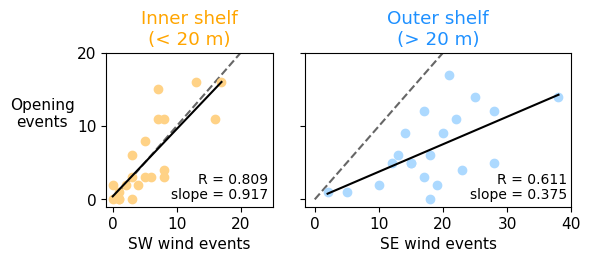

In [3712]:
from scipy import stats

cat = 'atm'

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.25,2]}, figsize=(6,2))

plt.subplots_adjust(wspace=0.15)

for ax in axs:
    ax.set_yticks([0,10,20])
    ax.set_ylim(-1,20)
    ax.plot([0,np.max(ax.get_ylim())], [0,np.max(ax.get_ylim())], c=[0.4,0.4,0.4], zorder=-1, linestyle='dashed')

ax = axs[0]
ax.set_ylabel('Opening\nevents', rotation=0, labelpad=25)
ax.set_title('Inner shelf\n(< 20 m)', c='orange')
ax.set_xlabel('SW wind events')
ax.set_xlim(-1,25)
ax.set_xticks([0,10,20])
    
x = cts[cat]['stro_sw'][years_cond]
y = counts['year']['lfbo_open']
res = stats.linregress(x, y)
print(res)
print(res.rvalue**2)
print()


ax.plot(x, y, 'o', c=lfbo_color)
xvals = np.array([x.min(), x.max()])
ax.plot(xvals, res.intercept + res.slope*xvals, c='k')

ax.text(1,0.15,f'R = {res.rvalue:.3f} ', ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.05,f'slope = {res.slope:.3f} ', ha='right', transform=ax.transAxes, size=10)

ax = axs[1]
ax.set_title('Outer shelf\n(> 20 m)', c='dodgerblue')
ax.set_xlabel('SE wind events')
ax.set_xlim(-1.5,40)
ax.set_xticks([0,10,20,30,40])
ax.set_yticklabels([])

x = cts[cat]['stro_se'][years_cond]
y = counts['year']['flaw_open']
res = stats.linregress(x, y)
print(res)
print(res.rvalue**2)


ax.plot(x, y, 'o', c=flaw_color)
xvals = np.array([x.min(), x.max()])
ax.plot(xvals, res.intercept + res.slope*xvals, c='k')

ax.text(1,0.15,f'R = {res.rvalue:.3f} ', ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.05,f'slope = {res.slope:.3f} ', ha='right', transform=ax.transAxes, size=10)

# ax.text(0.05,1, 'SW wind & Fast', 
#         c='orange', ha='left', va='bottom',
#         transform=ax.transAxes)

# ax.text(0.65,1, 'SE wind & Flaw', 
#         c='dodgerblue', ha='left', va='bottom',
#         transform=ax.transAxes)

fig.savefig('./figures/wind_correlations.png', dpi=500, bbox_inches='tight', pad_inches=0)

LinregressResult(slope=0.5535905680600214, intercept=-0.7470525187566981, rvalue=0.6535943316789781, pvalue=0.001312614945700919, stderr=0.147065426552052, intercept_stderr=3.6415931508913904)
0.42718555040288997



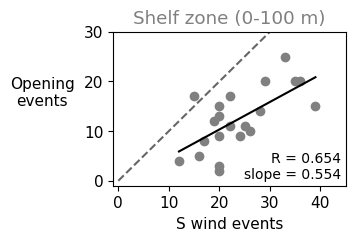

In [3485]:
from scipy import stats

cat = 'atm'

fig, ax = plt.subplots(figsize=(3,2))

ax.set_yticks([0,10,20,30])
ax.set_ylim(-1,30)
ax.set_xlim(-1,45)
ax.set_xticks([0,10,20,30,40])

ax.set_ylabel('Opening\nevents', rotation=0, labelpad=30)
ax.set_title('Shelf zone (0-100 m)', c='gray')
ax.set_xlabel('S wind events')

ax.plot([0,np.max(ax.get_ylim())], [0,np.max(ax.get_ylim())], c=[0.4,0.4,0.4], zorder=-1, linestyle='dashed')

    
x = cts[cat]['stro_sw'][years_cond] + cts[cat]['stro_se'][years_cond]
y = counts['year']['lfbo_open'] + counts['year']['flaw_open']
res = stats.linregress(x, y)
print(res)
print(res.rvalue**2)
print()


ax.plot(x, y, 'o', c='gray')
xvals = np.array([x.min(), x.max()])
ax.plot(xvals, res.intercept + res.slope*xvals, c='k')

ax.text(1,0.15,f'R = {res.rvalue:.3f} ', ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.05,f'slope = {res.slope:.3f} ', ha='right', transform=ax.transAxes, size=10)

fig.savefig('./figures/wind_correlationsall.png', dpi=500, bbox_inches='tight', pad_inches=0)

In [3358]:
0.6535943316*0.6535943316

0.4271855502996508

In [2938]:
cts[cat]['sw'][years_cond] + cts[cat]['se'][years_cond]  + cts[cat]['other'][years_cond]

array([90., 91., 90., 90., 90., 91., 90., 90., 90., 90., 90., 90., 91.,
       90., 90., 90., 91., 90., 90., 90., 91.])

R^2 = 0.141
R^2 = 0.494
R^2 = 0.105


Text(0.5, 0.85, '-3.1 days/decade')

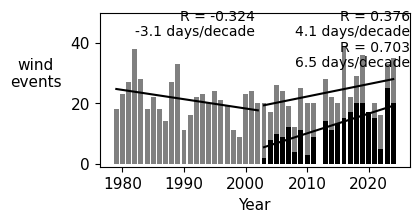

In [2980]:
from scipy import stats

cat = 'atm'

fig, ax = plt.subplots(figsize=(4,2))

plt.subplots_adjust(wspace=0.075)


# ax.set_yticks([0,10,20, 30])
ax.set_ylim(-1,50)
# ax.plot([0,np.max(ax.get_ylim())], [0,np.max(ax.get_ylim())], c=[0.4,0.4,0.4], zorder=-1, linestyle='dashed')


ax.set_ylabel('wind\nevents', rotation=0, labelpad=25)
# ax.set_title('Fast zone', c='orange')
ax.set_xlabel('Year')
# ax.set_xlim(-1,45)
# ax.set_xticks([0,10,20, 30, 40])
    


x = distinct_years[years_cond] 
y = (cts[cat]['stro_sw'] + cts[cat]['stro_se'])[years_cond]

corr = calc_correlation(x, y)
ax.bar(x, y,  color='gray')
xvals = np.array([x.min(), x.max()])
ax.plot(corr['x'], corr['y'], c='k')
ax.text(1,0.95,corr['R'], ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.85,f"{trend_per_dec(corr['res'].slope)}", ha='right', transform=ax.transAxes, size=10)


x = distinct_years[years_cond] 
y = counts['year']['lfbo_open'] + counts['year']['flaw_open']

corr = calc_correlation(x, y)
ax.bar(x, y,  color='k')
xvals = np.array([x.min(), x.max()])
ax.plot(corr['x'], corr['y'], c='k')
ax.text(1,0.75,corr['R'], ha='right', transform=ax.transAxes, size=10)
ax.text(1,0.65,f"{trend_per_dec(corr['res'].slope)}", ha='right', transform=ax.transAxes, size=10)





x = distinct_years[:24]
y = (cts[cat]['stro_sw'] + cts[cat]['stro_se'])[:24]

corr = calc_correlation(x, y)
ax.bar(x, y,  color='gray')
xvals = np.array([x.min(), x.max()])
ax.plot(corr['x'], corr['y'], c='k')
ax.text(0.5,0.95,corr['R'], ha='right', transform=ax.transAxes, size=10)
ax.text(0.5,0.85,f"{trend_per_dec(corr['res'].slope)}", ha='right', transform=ax.transAxes, size=10)





In [2962]:
def trend_per_dec(slope):
    
    per_decade = slope*10
    
    return f'{per_decade:.1f} days/decade'
    

In [2952]:
corr['res'].slope*10

-3.0739130434782607

In [2974]:
def calc_correlation(x, y,):
    
    x_nn = x[np.isfinite(x)&np.isfinite(y)]
    y_nn = y[np.isfinite(x)&np.isfinite(y)]
    
    res = stats.linregress(x_nn, y_nn)
    print(f'R^2 = {res.rvalue**2:.3f}')
    
    data = {}
    
    data['res'] = res
    
    data['x'] = np.array([x_nn.min(), x_nn.max()])
    data['y'] = res.intercept + res.slope*data['x']
    
    
    if res.pvalue < 0.0001:
        P = 'p < 0.0001'
    elif res.pvalue < 0.001:
         P = 'p < 0.001'
    elif res.pvalue < 0.01:
         P = 'p < 0.01'
    elif res.pvalue < 0.05:
         P = 'p < 0.05'
    elif res.pvalue < 0.1:
         P = 'p < 0.1'
    else:
        P = f'p = {res.pvalue:.1f}'
        
    data['p'] = P
    data['R'] = f'R = {res.rvalue:.3f}'
    data['slope'] = f'slope = {res.rvalue:.3f}'
    
    return data

In [2941]:
distinct_years[:25]

array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003])

In [2942]:
flaw_color = [0.675,0.85,1]
lfbo_color = [1,0.825,0.525]

<BarContainer object of 23 artists>

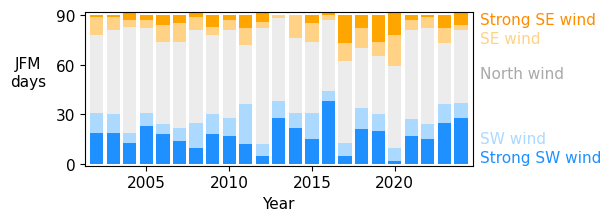

In [3330]:
fig, ax = plt.subplots(figsize=(5,2))
# ax.bar(distinct_years, mean_climorientation)


ax.set_xlabel('Year')
ax.set_ylabel('JFM\ndays', rotation=0, labelpad=20)
ax.set_xlim(distinct_years.min()-0.7,distinct_years.max()+0.7)
ax.set_ylim(-1,92)
ax.set_yticks([0,30,60,90]);

ax.text(1.02,0.95,'Strong SE wind', transform=ax.transAxes, c='darkorange', ha='left', va='center')
ax.text(1.02,0.825,'SE wind', transform=ax.transAxes, c=lfbo_color, ha='left', va='center')
ax.text(1.02,0.6,'North wind', transform=ax.transAxes, c='darkgray', ha='left', va='center')
ax.text(1.02,0.175,'SW wind', transform=ax.transAxes, c=flaw_color, ha='left', va='center')
ax.text(1.02,0.05,'Strong SW wind', transform=ax.transAxes, c='dodgerblue', ha='left', va='center')

key = 'atm'

total_days = cts[key]['se']+cts[key]['other']+cts[key]['sw']

# ax.bar([2012], [90], color='lightgray', alpha=1)
ax.bar(distinct_years, cts[key]['sw'], bottom = cts[key]['se']+cts[key]['other'], color=lfbo_color, alpha=1)
ax.bar(distinct_years, cts[key]['stro_sw'], bottom = total_days-cts[key]['stro_sw'],color='orange', alpha=1)

ax.bar(distinct_years, cts[key]['other'], bottom = cts[key]['se'], color=[0.925,0.925,0.925], alpha=1)
ax.bar(distinct_years, cts[key]['se'], color=flaw_color, alpha=1)
ax.bar(distinct_years, cts[key]['stro_se'],  color='dodgerblue', alpha=1)


# ax.text(0.5,0.7, 'fast opening', c='darkorange', ha='left', va='center', transform=ax.transAxes)
# ax.scatter(distinct_years[years_cond], total_days[years_cond] - counts['year']['lfbo_open'], 
#            c='orange', s = 20, edgecolor='k', lw=0.75, )
# ax.scatter(distinct_years[years_cond], counts['year']['flaw_open'], 
#            c='dodgerblue',s = 20, edgecolor='k', lw=0.75, )

# x = distinct_years
# runmean = running_mean(cts[key]['stro_sw'], length = 2, center=True)
# ax.plot(x, 90-runmean, c='k')
# # ax.fill_between(x, np.zeros_like(x)+90, 90-runmean,  color='k', alpha=0.5, lw=0)

# runmean = running_mean(cts[key]['stro_se'], length = 2, center=True)
# ax.plot(x, runmean, c='k')
# ax.fill_between(x, np.zeros_like(x), runmean,  color='k', alpha=0.5, lw=0)

# fig.savefig('./figures/wind_timeseries.png', dpi=500, bbox_inches='tight', pad_inches=0)


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3213/4089117753.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(theta, r,  s=20, lw=1,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_3213/4089117753.py:70: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(theta, r, s=20, lw=1,


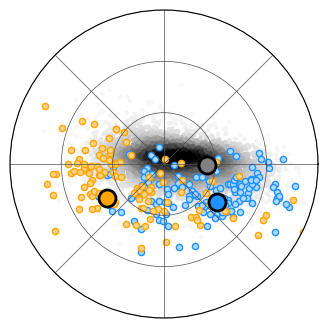

In [2944]:
fig = plt.figure(figsize = (4,4))
ax = plt.subplot(111, polar=True)
 
ax.set_rlim(0,30)
ax.set_rticks([10,20,30])

# ax.set_rlim(0,15)
# ax.set_rticks([5,10,15])

ax.set_xticklabels([])
ax.patch.set_facecolor('white')
ax.grid(color=[0.3,0.3,0.3], linestyle='-', linewidth=0.5)
ax.set_yticklabels([])



group = 'clim'

theta = np.arctan2(region_atm[group]['vg'], region_atm[group]['ug'])
theta-=np.pi

mean_R = np.nanmean(np.sqrt(region_atm[group]['vg']**2 +region_atm[group]['ug']**2))
mean_theta = np.arctan2(np.nanmean(region_atm[group]['vg']), np.nanmean(region_atm[group]['ug'])) - np.pi

# ax.plot([mean_theta,mean_theta], [0,mean_R], c = 'k', lw=5, zorder=10)
# ax.plot([mean_theta,mean_theta], [0,mean_R], c = 'gray', lw=4, zorder=10)

ax.scatter([mean_theta], [mean_R], c = 'gray', s=150, edgecolor='k', lw=2, zorder=10)

theta[theta<0]+=2*np.pi
r = np.sqrt(region_atm[group]['vg']**2+region_atm[group]['ug']**2)
# plt.scatter(theta, r, s=5, 
#             c=[0.3,0.3,0.3])#[0.8,0.8,0.8]

# Calculate the point density
xy = np.vstack([region_atm[group]['ug'],region_atm[group]['vg']])
z = gaussian_kde(xy)(xy)
ax.scatter(theta, r, c=z, s=5, cmap='Greys', vmin=-0.0003, vmax=0.005)





group = 'flaw_open'
theta = np.arctan2(region_atm[group]['vg'], region_atm[group]['ug'])
theta-=np.pi

theta[theta<0]+=2*np.pi
r = np.sqrt(region_atm[group]['vg']**2+region_atm[group]['ug']**2)
plt.scatter(theta, r,  s=20, lw=1,
            c=flaw_color, edgecolor='dodgerblue')



mean_R = np.nanmean(np.sqrt(region_atm[group]['vg']**2 +region_atm[group]['ug']**2))
mean_theta = np.arctan2(np.nanmean(region_atm[group]['vg']), np.nanmean(region_atm[group]['ug'])) - np.pi

# ax.plot([mean_theta,mean_theta], [0,mean_R], c = 'k', lw=5, zorder=10)
# ax.plot([mean_theta,mean_theta], [0,mean_R], c = 'dodgerblue', lw=4, zorder=10)
ax.scatter([mean_theta], [mean_R], c = 'dodgerblue', s=150, edgecolor='k', lw=2, zorder=10)



group = 'lfbo_open'
theta = np.arctan2(region_atm[group]['vg'], region_atm[group]['ug'])
theta-=np.pi

theta[theta<0]+=2*np.pi
r = np.sqrt(region_atm[group]['vg']**2+region_atm[group]['ug']**2)
plt.scatter(theta, r, s=20, lw=1,
            c=lfbo_color, edgecolor='orange')

mean_R = np.nanmean(np.sqrt(region_atm[group]['vg']**2 +region_atm[group]['ug']**2))
mean_theta = np.arctan2(np.nanmean(region_atm[group]['vg']), np.nanmean(region_atm[group]['ug'])) - np.pi

# ax.plot([mean_theta,mean_theta], [0,mean_R], c = 'k', lw=5, zorder=10)
# ax.plot([mean_theta,mean_theta], [0,mean_R], c = 'orange', lw=4, zorder=10)
ax.scatter([mean_theta], [mean_R], c = 'orange', s=150, edgecolor='k', lw=2, zorder=10)






# clim speeds
# theta = mid_point_bins * np.pi/180
# theta-=np.pi
# width = 2*np.pi / len(mid_point_bins)
# theta = np.append(theta, theta[0])

# r = speed_bins['mean']
# r = np.append(r, r[0])
# # ax.plot(theta, r, c='k')
# bars = ax.bar(theta, r, 
#               width=width, bottom=0,color='k', edgecolor='k', zorder=-4)

# cond = (mid_point_bins >=-180)&(mid_point_bins <= 0)
# color = [0.925,0.925,0.925]
# bars = ax.bar(theta[:-1][cond], r[:-1][cond]-0.35, 
#               width=1*width,bottom=0,color=color, edgecolor=color, zorder=-2)
# bars = ax.bar(theta[:-1][cond], 30-r[:-1][cond], 
#               width=width, bottom=r[:-1][cond],color=color, edgecolor=color, zorder=-6)


# cond = (mid_point_bins >= 7.5)&(mid_point_bins <= 82.5)
# bars = ax.bar(theta[:-1][cond], r[:-1][cond]-0.35, 
#               width=1*width,bottom=0,color=lfbo_color, edgecolor=lfbo_color, zorder=-3)
# bars = ax.bar(theta[:-1][cond], 30-r[:-1][cond], 
#               width=width,bottom=r[:-1][cond],color='orange', edgecolor='orange', zorder=-6)


# cond = (mid_point_bins > 82.5)&(mid_point_bins <= 172.5)
# bars = ax.bar(theta[:-1][cond], r[:-1][cond]-0.35, 
#               width=1*width,bottom=0,color=flaw_color, edgecolor=flaw_color, zorder=-3)
# bars = ax.bar(theta[:-1][cond], 30-r[:-1][cond], 
#               width=width,bottom=r[:-1][cond],color='dodgerblue', edgecolor='dodgerblue', zorder=-6)



# fig.savefig('./figures/wind_directions_generalized.png', dpi=500, pad_inches=0, bbox_inches='tight', transparent=True)
fig.savefig('./figures/wind_directions_spec.png', dpi=500, pad_inches=0, bbox_inches='tight', transparent=True)




LinregressResult(slope=0.224846328049175, intercept=-449.1250943599698, rvalue=0.43226054705820305, pvalue=0.05035226438447591, stderr=0.10760908839045032, intercept_stderr=216.67970956887262)


<BarContainer object of 21 artists>

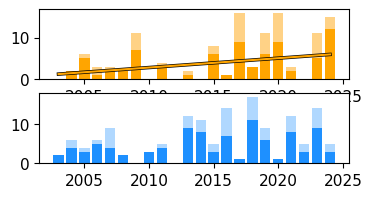

In [2945]:
fig, axs = plt.subplots(2,1, figsize=(4,2))

# years_cond = ((distinct_years!=2012)&(distinct_years>2002))

ax = axs[0]
x = distinct_years[years_cond]
y = counts['year']['lfbo']

x_nn = x[np.isfinite(x)&np.isfinite(y)]
y_nn = y[np.isfinite(x)&np.isfinite(y)]
res = stats.linregress(x_nn, y_nn)
print(res)


ax.bar(distinct_years[years_cond], counts['year']['lfbo_open'], color=[1,0.825,0.525])
ax.bar(distinct_years[years_cond], counts['year']['lfbo'], color='orange')
# ax.scatter(x, y, color='orange')

xs = np.array([np.min(x_nn), np.max(x_nn)])
ax.plot(xs, res.intercept + res.slope*xs, c='k', lw=2.5)
ax.plot(xs, res.intercept + res.slope*xs, c='orange')

ax = axs[1]
ax.bar(distinct_years[years_cond], counts['year']['flaw_open'], color='dodgerblue', alpha=0.35)
ax.bar(distinct_years[years_cond], counts['year']['flaw'], color='dodgerblue')


In [2946]:

def running_mean(series, length = 3, center=False):
    
    # copy data
    variable = np.copy(series)
    running_sum = np.copy(variable)

    # end values are nans
    if center:
        running_sum[:length] = np.nan
        running_sum[-length:] = np.nan
        for ii in range(length, len(running_sum)-length):
            running_sum[ii] = np.sum(variable[ii-length:ii+length+1]) / len(variable[ii-length:ii+length+1])
        
    else:
        running_sum[:length] = np.nan
        for ii in range(length, len(running_sum)):
            running_sum[ii] = np.sum(variable[ii-length:ii+1]) / len(variable[ii-length:ii+1])
        
        
    return running_sum

        
    

LinregressResult(slope=0.14031620553359683, intercept=-264.89130434782606, rvalue=0.11699553332066602, pvalue=0.5949805895509603, stderr=0.2599178293838003, intercept_stderr=523.217431173894)
LinregressResult(slope=0.2737154150197628, intercept=-545.5978260869564, rvalue=0.39039339302670684, pvalue=0.0655167823022311, stderr=0.14085777709654995, intercept_stderr=283.548244720434)


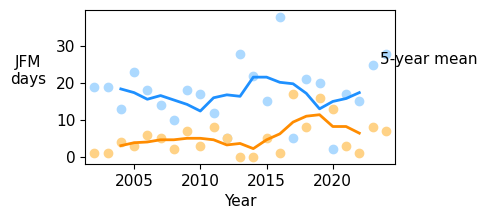

In [3721]:
fig, ax = plt.subplots(figsize=(4,2))

# ax.set_ylim(0,45)
# ax.set_yticks([0,15,30,45])
ax.set_xlabel('Year')
ax.set_ylabel('JFM\ndays', rotation=0, labelpad=20)
ax.set_xlim(distinct_years.min()-0.7,distinct_years.max()+0.7)


key='atm'
x = distinct_years
y = cts[key]['stro_se']
res = stats.linregress(x, y)
print(res)

# plt.plot(x, y, 'o', c='lightcoral', label='original data')
ax.scatter(x, y, color=[0.675,0.85,1])

runmean = running_mean(y, length = 2, center=True)
ax.plot(x, runmean, c='dodgerblue', lw=2)

ax.text(0.95,0.65, '5-year mean', transform=ax.transAxes)


key='atm'
x = distinct_years
y = cts[key]['stro_sw']
res = stats.linregress(x, y)
print(res)


ax.scatter(x, y, color=[1,0.825,0.525])

runmean = running_mean(y, length = 2, center=True)
ax.plot(x, runmean, c='darkorange', lw=2)


# plt.plot(x, res.intercept + res.slope*x, c='lightcoral', label='fitted line')

length = 5
variable = np.copy(y)
running_sum = np.copy(variable)
running_sum[:length] = np.nan
for ii in range(length, len(running_sum)):
    running_sum[ii] = np.sum(variable[ii-length:ii+1]) / (length+1)


fig.savefig('./figures/wind_runningmean.png', dpi=500, bbox_inches='tight', pad_inches=0)




LinregressResult(slope=0.4065998821449617, intercept=0.566440777843253, rvalue=0.7945721897227366, pvalue=2.856169913521077e-05, stderr=0.07323315091349275, intercept_stderr=0.6447013381680515)
LinregressResult(slope=0.3100523490822345, intercept=0.3557749652110527, rvalue=0.6303592340862053, pvalue=0.0028884131536560252, stderr=0.08999994393362101, intercept_stderr=1.3635808312652418)


Text(0.5, 0, 'wind enhance/reverse')

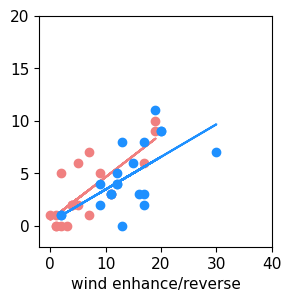

In [2031]:
fig, ax = plt.subplots(figsize=(3,3))
plt.ylim(-2,20)
plt.xlim(-2,40)


key = 'atm'

# years_cond = ((distinct_years!=2012)&(distinct_years>2002))
# years_cond2 = distinct_years[years_cond]!=2025

x = cts[key]['stro_sw'][years_cond]
y = counts['year']['lfbo']
res = stats.linregress(x, y)
print(res)

plt.plot(x, y, 'o', c='lightcoral', label='original data')
plt.plot(x, res.intercept + res.slope*x, c='lightcoral', label='fitted line')

x = cts[key]['stro_se'][years_cond]
y = counts['year']['flaw']
res = stats.linregress(x, y)
print(res)

plt.plot(x, y, 'o', c='dodgerblue', label='original data')
plt.plot(x, res.intercept + res.slope*x, c='dodgerblue', label='fitted line')


plt.xlabel('wind enhance/reverse')

## Indidivudal plots

In [ ]:


ti = 0

group = 'lfbo_open'

for ti in range(0,len(events[group]['date'])):
    
#     date = pd.to_datetime(DSM[group].time[ti].values)
    date = pd.to_datetime(events[group]['date'][ti])

    DATE = date.strftime('%Y-%m-%d')
    du = DSM[group].u10.sel(time=date) - DSM['clim'].u10.mean(dim='time')
    dv = DSM[group].v10.sel(time=date) - DSM['clim'].v10.mean(dim='time')
    local_msl = DSM[group].msl.sel(time=date, latitude=71, longitude = -153)/100
    msl_data = DSM[group].msl.sel(time=date)/100 - local_msl
    
    vec_diff = np.sqrt(du**2+dv**2)

    
    
    
    fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-150)), figsize=(6,6))
    ax.set_facecolor('lightgray')
    ax.coastlines(zorder=1)
    # ax.gridlines()

    # abv_dc1 = (atm['flaw']['dc'] - atm['clim']['dc']) > 0.25
    # abv_dc2 = (atm['lfbo']['dc'] - atm['clim']['dc']) > 0.25

    
    ax.contour(XX, YY, ds.avg.values[ai:aj, bi:bj],
           levels=[ -100,-20], colors=['gray'], linewidths=[0.75,0.75], 
           linestyles='solid', zorder=100, transform=sic['proj'])

    

    ax.set_extent([185,225,68,81], crs=ccrs.PlateCarree())


    
    ax.contour(longrid, latgrid, ma.masked_where(longrid<100, msl_data),
               levels = np.arange(-40,41,2), colors='k',
                  zorder=0, transform=ccrs.PlateCarree())


    poly_lons = np.array([-156.5, -155, -154, -153, -152, -151, -150, -149,
                          -149, -150,-151,-152,-153,-154,-155, -156.5, 
                          -156.5])
    poly_lats = np.array([71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 
                          70.35, 70.35, 70.35, 70.35, 70.35, 70.35, 70.35, 70.35,
                          71.85])

    ax.plot(poly_lons, poly_lats,lw=0.5, c='k', transform=ccrs.Geodetic())
    
    # open sic data
    sic = UNISIC.open_local_file(date, res='6250', hem='n', 
                                         main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                         coordinates=False, area=False, include_units=False, quiet=True)
    sp = 1
    ax.pcolormesh(sic['xx'][::sp,::sp], sic['yy'][::sp,::sp], sic['sic'][::sp,::sp],
                 vmin=0,vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'], zorder=-1)
    ax.contour(sic['xx'][::sp,::sp], sic['yy'][::sp,::sp], sic['sic'][::sp,::sp],
               levels=[68], colors='gold', linewidths=0.5, transform=sic['proj'], zorder=-1)
    
    
    drift = PPdrift.open_local_file(date,
                                        main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/',
                                        filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                                        include_units = False)
    
    
    quiverkwargs = {'scale_units':'xy', 'scale':0.0005, 'width':0.002, 'headwidth':5, 'color':'gray'}
    sp = 4
    qv = ax.quiver(drift['xx'][::sp,::sp], drift['yy'][::sp,::sp], 
              drift['u'][::sp,::sp], 
              drift['v'][::sp,::sp], 
              transform=drift['proj'], **quiverkwargs)

    
#     if events['lfbo']['area'][ti] < 50:
#         ax.set_title(f'{DATE} [{group}] ({events['lfbo']['area'][ti]:.0f} sq. km)', c='r')
# #     elif events[group]['area'][ti] < 1000:
# #         ax.set_title(f'{DATE} [{group}] ({events[group]['area'][ti]:.0f} sq. km)', c='gray')
#     else:
    ax.set_title(f'{DATE} [{group}] ({events[group]['area'][ti]:.0f} sq. km)', c='gray')

    fig.savefig(f'/Users/mackenziejewell/Desktop/atm_maps/v2/sic_{group}_{DATE}.png', 
                dpi=300, pad_inches=0, bbox_inches='tight')

    plt.clf()
    fig.clear()

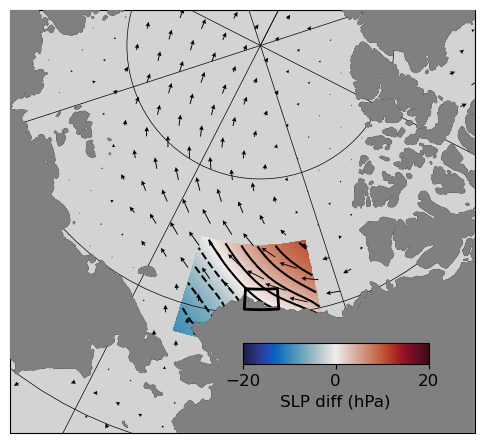

In [2982]:

group = 'flaw_open'

DATE = date.strftime('%Y-%m-%d')
du = DSM[group].u10.sel(time=events[group]['date']).mean(dim='time') - DSM['clim'].u10.mean(dim='time')
dv = DSM[group].v10.sel(time=events[group]['date']).mean(dim='time') - DSM['clim'].v10.mean(dim='time')
local_msl = DSM[group].msl.sel(time=events[group]['date'], latitude=71, longitude = -153).mean(dim='time')/100
msl_data = DSM[group].msl.sel(time=events[group]['date']).mean(dim='time')/100 - local_msl

vec_diff = np.sqrt(du**2+dv**2)




fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-153)), figsize=(6,6))
ax.set_facecolor('lightgray')
ax.coastlines(zorder=1)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='gray'), zorder=10)
# ax.set_title(group)

# ax.set_xlim(-500000,800000)
# ax.set_ylim(-2300000,-1900000)

# ax.set_xlim(-500000,1000000)
# ax.set_ylim(-2800000,-1500000)


ax.set_xlim(-2100000,1800000)
ax.set_ylim(-3250000,300000)


# ax.set_extent([185,225,68,81], crs=ccrs.PlateCarree())





# ax.gridlines()

# abv_dc1 = (atm['flaw']['dc'] - atm['clim']['dc']) > 0.25
# abv_dc2 = (atm['lfbo']['dc'] - atm['clim']['dc']) > 0.25


# ax.pcolormesh(longrid, latgrid, vec_diff,
#               vmin=0, vmax=8, cmap='viridis', zorder=0, transform=ccrs.PlateCarree())



mesh = ax.pcolormesh(longrid, latgrid, msl_data,
              vmin=-20, vmax=20, cmap=cmocean.cm.balance, zorder=0, transform=ccrs.PlateCarree())

add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
             cb_width='auto', cb_length_fraction=[0.5, 0.9], cb_pad=-0.15, cb_ticks='auto', 
             cb_ticklabels='auto', cb_extend='neither', cb_label='SLP diff (hPa)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None,
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


ax.contour(longrid, latgrid, ma.masked_where(longrid<10, msl_data),
           levels = np.arange(-40,41,2), colors='k',
              zorder=0, transform=ccrs.PlateCarree())


poly_lons = np.array([-156.5, -155, -154, -153, -152, -151, -150, -149,
                      -149, -150,-151,-152,-153,-154,-155, -156.5, 
                      -156.5])
poly_lats = np.array([71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 
                      70.35, 70.35, 70.35, 70.35, 70.35, 70.35, 70.35, 70.35,
                      71.85])

ax.plot(poly_lons, poly_lats,lw=2, c='k', zorder=100, transform=ccrs.Geodetic())



# ax.contour(XX, YY, ds.avg.values[ai:aj, bi:bj],
#        levels=[ -50,-20], colors=['gray'], linewidths=[0.75,0.75], 
#        linestyles='solid', zorder=100, transform=sic['proj'])



# # open sic data
# sic = UNISIC.open_local_file(date, res='6250', hem='n', 
#                                      main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                                      coordinates=False, area=False, include_units=False, quiet=True)
# sp = 1
# ax.pcolormesh(sic['xx'][::sp,::sp], sic['yy'][::sp,::sp], sic['sic'][::sp,::sp],
#              vmin=0,vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'], zorder=-1)
# ax.contour(sic['xx'][::sp,::sp], sic['yy'][::sp,::sp], sic['sic'][::sp,::sp],
#            levels=[68], colors='gold', linewidths=0.5, transform=sic['proj'], zorder=-1)


# drift = PPdrift.open_local_file(date,
#                                     main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/',
#                                     filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
#                                     include_units = False)


quiverkwargs = {'scale_units':'xy', 'scale':0.00008, 'width':0.002, 'headwidth':5, 'color':'k'}
sp = 8
qv = ax.quiver(drift['xx'][::sp,::sp], drift['yy'][::sp,::sp], 
              OSM[group]['u'].mean(dim='time').values[::sp,::sp], 
              OSM[group]['v'].mean(dim='time').values[::sp,::sp], 
              transform=drift['proj'], **quiverkwargs, zorder=100)



line_kwargs = {'lw':0.5, 'c':'k'}
for lat in np.arange(60,91,10):
    ax.plot(np.linspace(0,360,100), np.full(100, lat),**line_kwargs, transform=ccrs.PlateCarree())
for lon in np.arange(0,361,45):
    ax.plot(np.full(100, lon), np.linspace(55,90,100), **line_kwargs, transform=ccrs.PlateCarree())

    
    


fig.savefig(f'./figures/atmforcing_large_{group}.png', 
            dpi=500, pad_inches=0, bbox_inches='tight')


In [59]:
OSM[group]['u'].mean(dim='time').values[::sp,::sp].shape

(46, 46)

In [57]:
drift['xx'][::sp,::sp].shape

(46, 46)

In [54]:
drift = PPdrift.open_local_file(date,
                                    main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/',
                                    filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                                    include_units = False)

## Composite timeseries winds

In [2143]:

days = 9
desired_dt = np.arange(-days, days+1)

all_vals = {}

all_vals['lfbo'] = {}
all_vals['flaw'] = {}

all_vals['lfbo_distinct'] = {}
all_vals['flaw_distinct'] = {}

for group in all_vals.keys():

    all_vals[group]['u10'] = np.array([])
    all_vals[group]['v10'] = np.array([])


    for date in events[group]['date']:

        d1 = date-timedelta(days=days)
        d2 = date+timedelta(days=days)
        if d1.month not in [1,2,3]:
            d1 = datetime(date.year, 1, 1)
        if d2.month not in [1,2,3]:
            d2 = datetime(date.year, 3, 31)

        times = pd.date_range(d1, d2)
        dt = np.array(list((times - date).days))

        for var in all_vals[group].keys():

            vals = region_atm['clim'][var].sel(time=times).values

            # fill missing data with nans
            desired_vals = np.zeros(len(desired_dt))
            for ii in range(len(desired_dt)):

                where_in = np.where(dt == desired_dt[ii])[0]
                if len(where_in) == 0:
                    desired_vals[ii] = np.nan
                else:
                    desired_vals[ii] = vals[where_in]

            all_vals[group][var] = np.append(all_vals[group][var], desired_vals)

    for var in all_vals[group].keys():
        all_vals[group][var] = np.reshape(all_vals[group][var], (len(events[group]['date']), len(desired_dt)))

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_61227/291002334.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  desired_vals[ii] = vals[where_in]


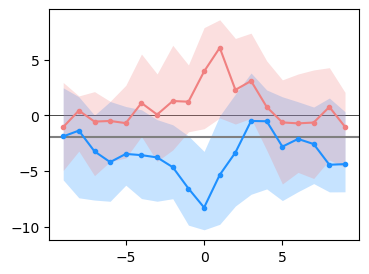

In [2148]:
# for ii in range(np.shape(vals_reshape)[0]):
#     plt.plot(desired_dt, vals_reshape[ii,:])
    
fig, ax = plt.subplots(figsize=(4,3))
    
var = 'u10'

ax.axhline(0, lw=0.5, zorder=-2, c='k')


# avg_u = np.nanmean(region_atm['clim']['u10'])
# avg_v = np.nanmean(region_atm['clim']['v10'])
# avg_mag = np.sqrt(avg_u**2+avg_v**2)
# ax.axhline(avg_mag, c='gray')
ax.axhline(region_atm['clim'][var].mean(dim='time'), c='gray')


group = 'flaw_distinct'
c = 'dodgerblue'
plotdata = all_vals[group][var]#(all_vals[group]['u10'] * avg_u + all_vals[group]['v10'] * avg_v)/avg_mag
plt.plot(desired_dt, np.nanmedian(plotdata, axis=0), c=c, marker='.')
plt.fill_between(desired_dt, 
                 np.nanpercentile(plotdata, 25, axis=0), 
                 np.nanpercentile(plotdata, 75, axis=0), color=c, alpha=0.25, lw=0)

group = 'lfbo_distinct'
c = 'lightcoral'
plotdata = all_vals[group][var]#(all_vals[group]['u10'] * avg_u + all_vals[group]['v10'] * avg_v)/avg_mag
plt.plot(desired_dt, np.nanmedian(plotdata, axis=0), c=c, marker='.')
plt.fill_between(desired_dt, 
                 np.nanpercentile(plotdata, 25, axis=0), 
                 np.nanpercentile(plotdata, 75, axis=0), color=c, alpha=0.25, lw=0)

# plt.plot(desired_dt, np.nanmedian(all_vals[group][var], axis=0), c=c, marker='.')
# plt.fill_between(desired_dt, 
#                  np.nanpercentile(all_vals[group][var], 25, axis=0), 
#                  np.nanpercentile(all_vals[group][var], 75, axis=0), color=c, alpha=0.25, lw=0)

In [2041]:
var = 'u10'
region_atm['clim'][var].time.values

array(['1980-01-01T00:00:00.000000000', '1980-01-02T00:00:00.000000000',
       '1980-01-03T00:00:00.000000000', ...,
       '2023-03-29T00:00:00.000000000', '2023-03-30T00:00:00.000000000',
       '2023-03-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [2033]:
pd.to_datetime(region_atm['clim'][var].time.values)

TypeError: unhashable type: 'list'

In [2133]:
clim_years = pd.to_datetime(region_atm['clim'][var].time.values).year

days = 15
dt = np.arange(-days, days+1)
all_chance = np.array([])

num_events = 0
series_length = 0
for year in distinct_years:
    
    current_vals = {}
    current_vals['u10'] = region_atm['clim']['u10'][clim_years==year].values
    current_vals['v10'] = region_atm['clim']['v10'][clim_years==year].values
    
    series_length+=len(np.arange(days, len(current_vals['u10'])-days))
    
    for vv in range(days, len(current_vals['u10'])-days):
        
        cond1 = (current_vals['u10'][vv] > 0) & (current_vals['v10'][vv] > 0)
        cond2 = np.sqrt(current_vals['u10'][vv]**2+current_vals['v10'][vv]**2) > 7
        
        if cond1&cond2:
            
            num_events+=1
            
            cond1 = (current_vals['u10'][vv-days:vv+days+1] < 0) & (current_vals['v10'][vv-days:vv+days+1] > 0)
            cond2 = np.sqrt(current_vals['u10'][vv-days:vv+days+1]**2+current_vals['v10'][vv-days:vv+days+1]**2) > 0
        
            likelihood = (cond1&cond2).astype(int)
            
            all_chance = np.append(all_chance, likelihood)
            
            
all_chance = np.reshape(all_chance, (num_events, len(dt)))

# bg_chance = num_events/series_length

cond1 = (region_atm['clim']['u10'] < 0) & (region_atm['clim']['v10'] > 0)
cond2 = np.sqrt(region_atm['clim']['u10']**2+region_atm['clim']['v10']**2) > 0
bg_chance = np.sum(cond1.values&cond2.values)/series_length

<BarContainer object of 31 artists>

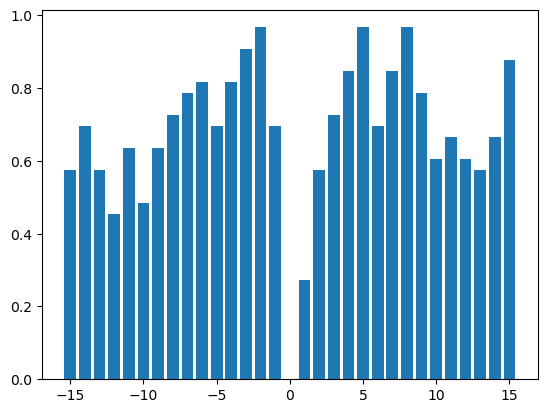

In [2134]:
plt.bar(dt, np.nanmean(all_chance, axis=0)/bg_chance)
# plt.axhline(bg_chance)

## Composite timeseries ice drift

In [1258]:

days = 9
desired_dt = np.arange(-days, days+1)

all_vals = {}

all_vals['lfbo'] = {}
all_vals['flaw'] = {}

for group in all_vals.keys():

    all_vals[group]['e'] = np.array([])
    all_vals[group]['n'] = np.array([])

    for date in events[group]['date']:

        d1 = date-timedelta(days=days)
        d2 = date+timedelta(days=days)
        if d1.month not in [1,2,3]:
            d1 = datetime(date.year, 1, 1)
        if d2.month not in [1,2,3]:
            d2 = datetime(date.year, 3, 31)

        times = pd.date_range(d1, d2)
        dt = np.array(list((times - date).days))
        
        for var in all_vals[group].keys():
            
            vals = np.array([])
            for datec in times:
                where_in = np.where(OSM['clim'].time.values == datec)[0]
                if len(where_in) == 0:
                    vals = np.append(vals, np.nan)
                    print(True)
                else:
                    vals = np.append(vals, region_ice['clim'][var][where_in])
            
            # fill missing data with nans
            desired_vals = np.zeros(len(desired_dt))
            for ii in range(len(desired_dt)):
                where_in = np.where(dt == desired_dt[ii])[0]
                if len(where_in) == 0:
                    desired_vals[ii] = np.nan
                else:
                    desired_vals[ii] = vals[where_in]

            all_vals[group][var] = np.append(all_vals[group][var], desired_vals)

    for var in all_vals[group].keys():
        all_vals[group][var] = np.reshape(all_vals[group][var], (len(events[group]['date']), len(desired_dt)))

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_61227/2597127269.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  desired_vals[ii] = vals[where_in]


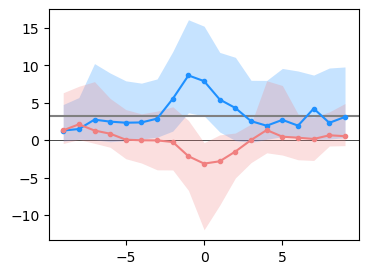

In [1265]:
# for ii in range(np.shape(vals_reshape)[0]):
#     plt.plot(desired_dt, vals_reshape[ii,:])
    
fig, ax = plt.subplots(figsize=(4,3))
    
var = 'n'

ax.axhline(0, lw=0.5, zorder=-2, c='k')

avg_u = np.nanmean(region_ice['clim']['e'])
avg_v = np.nanmean(region_ice['clim']['n'])
avg_mag = np.sqrt(avg_u**2+avg_v**2)
ax.axhline(avg_mag, c='gray')
# ax.axhline(np.nanmean(region_ice['clim'][var]), c='gray')


group = 'flaw'
c = 'dodgerblue'
# plotdata = all_vals[group][var]
plotdata = (all_vals[group]['e'] * avg_u + all_vals[group]['n'] * avg_v)/avg_mag
plt.plot(desired_dt, np.nanmedian(plotdata, axis=0), c=c, marker='.')
plt.fill_between(desired_dt, 
                 np.nanpercentile(plotdata, 25, axis=0), 
                 np.nanpercentile(plotdata, 75, axis=0), color=c, alpha=0.25, lw=0)
group = 'lfbo'
c = 'lightcoral'
plotdata = (all_vals[group]['e'] * avg_u + all_vals[group]['n'] * avg_v)/avg_mag
plt.plot(desired_dt, np.nanmedian(plotdata, axis=0), c=c, marker='.')
plt.fill_between(desired_dt, 
                 np.nanpercentile(plotdata, 25, axis=0), 
                 np.nanpercentile(plotdata, 75, axis=0), color=c, alpha=0.25, lw=0)


In [1250]:
region_ice['clim']['n']

array([ 2.83540344,  0.7145431 , -3.24223733, ...,  1.55420613,
        8.24078083, 10.13964558])

In [1248]:
avg_u = region_ice['clim']['e']
avg_v = region_ice['clim']['n']
avg_mag = np.sqrt(avg_u**2+avg_v**2)

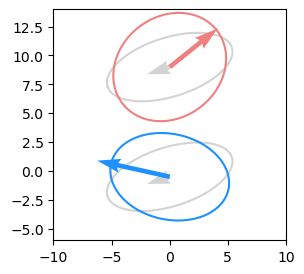

### Ice drift statistics

### Import bathymetry data

### Show both

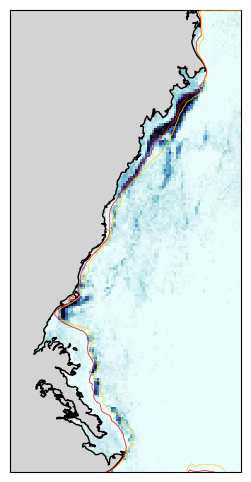

In [4]:

fig, ax = plt.subplots(subplot_kw=dict(projection=data['sic']['proj']), figsize=(6,6))
ax.set_facecolor('lightgray')
ax.coastlines()

ax.set_xlim(-2400000,-1800000)
ax.set_ylim(-300000,900000)

ax.pcolormesh(data['sic']['xx'], data['sic']['yy'], data['sic']['sic'], vmin=0, vmax=100, cmap=cmocean.cm.ice)

ax.contour(XX, YY, ds.avg.values[ai:aj, bi:bj], 
           levels=[-30,-20], colors=['gold','r'], linewidths=[0.5,0.5], zorder=100)


In [6]:


#0=clouds, 1=land, 2=sea ice, 3=artefacts, 4=leads, 5=open water.
lead_cmap = matplotlib.colors.ListedColormap(['lightgray', 'gray', 'white', 'orange', 'dodgerblue', 'blue'])

def open_local_lead_file(year, crop_i = [1400, 2200], crop_j = [600, 1200]):
    
    # crop_i is range to crop i index
    # crop_j is range to crop j index
    
    # JFMA year corresponds to second year of file
    # Nov. year1 -- Apr. year2
    
    # open data file
    #0=clouds, 1=land, 2=sea ice, 3=artefacts, 4=leads, 5=open water.
    da = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ArcLeads/{year-1}{str(year)[-2:]}_ArcLeads.nc')
    da.close()
    
    # interpret file dates
    # note that seocond set of dates (those after Jan 1) list the wrong (previous) year
    dates1 = [datetime.strptime(time, '%Y%m%d') for time in da.time.values[:61].astype(str)]
    dates2 = [datetime(int(time[:4])+1, int(time[4:6]), int(time[6:])) for time in da.time.values[61:].astype(str)]
    dates = np.append(dates1, dates2)
    
    # crop
    ai, bi = crop_i[0], crop_i[1]
    aj, bj = crop_j[0], crop_j[1]
    
    # grab coordinates
    lats = da.lat[ai:bi, aj:bj]
    lons = da.lon[ai:bi, aj:bj]
    
    # lea map
    lead_map = da.leadmap[:, ai:bi, aj:bj]
    
    return lons, lats, dates, lead_map



# masks for inner and outer shelves

In [7]:
# open file
year = 2003
lons, lats, dates, lead_map = open_local_lead_file(year, crop_i = [1590, 1855], crop_j = [780, 980])
    
out = data['sic']['proj'].transform_points(ccrs.PlateCarree(), lons.values, lats.values)
lon_xx = out[:,:,0]
lat_yy = out[:,:,1]

inner = np.full(lat_yy.shape, False)
middle = np.full(lat_yy.shape, False)


# cropped elevation data, with XX, YY coords
elev_mean = ds.avg.values[ai:aj, bi:bj]

for ii in range(lat_yy.shape[0]):
    for jj in range(lat_yy.shape[1]):
        
        if (lons[ii, jj] > -156.5) & (lons[ii, jj] < -149):
#         if (lons[ii, jj] > -156) & (lons[ii, jj] < -149.5):
            
            if (lats[ii, jj] > 70.35) & (lats[ii, jj] < 71.85):
        
                if (ii%100==0)&(jj%100==0):
                    print(ii, jj)

                dx = (XX - lon_xx[ii,jj])
                dy = (YY - lat_yy[ii,jj])

                dist = np.sqrt(dx**2+dy**2)

                nearest_elev = elev_mean[np.where(dist == np.min(dist))][0]

                if ((nearest_elev < -20) & (nearest_elev > -50)):
                    middle[ii, jj] = True
#                 elif ((nearest_elev < -3) & (nearest_elev > -15)):
                elif ((nearest_elev < -4) & (nearest_elev > -20)):
                    inner[ii, jj] = True

0 100
100 100
200 0
200 100


In [8]:
# years = [2011, 2017, 2020]

# years = [2013, 2016, 2018,2021]

# years = [2008]
years = np.arange(2003, 2023)

for year in years:
    
    print(year)

    # open file
    lons, lats, dates, lead_map = open_local_lead_file(year, crop_i = [1590, 1855], crop_j = [780, 980])
    
    
    if year == years[0]:
        lead_counts = np.zeros(lats.shape)
        total_counts = np.zeros(lats.shape)

    
    # find Jan - Mar dates for year
    tind_1 = np.where(dates == datetime(year,1,1))[0][0]
    tind_2 = np.where(dates == datetime(year,3,31))[0][0]

    # crop to time range
    overall_map = lead_map[tind_1:tind_2+1]
    
    # calculate counts along time axis
    
    num_leads = np.sum(overall_map == 4, axis=0).values
    num_open = np.sum(overall_map == 5, axis=0).values
    num_noncloud = np.sum(overall_map != 0, axis=0).values
    land = np.sum(overall_map == 1, axis=0).values > 0
    
    lead_counts += (num_leads+num_open)
    total_counts += num_noncloud


mean_freq = lead_counts/total_counts

longterm_freq = mean_freq

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [228]:
# CYC_freq = mean_freq

In [229]:
# BH_freq = mean_freq

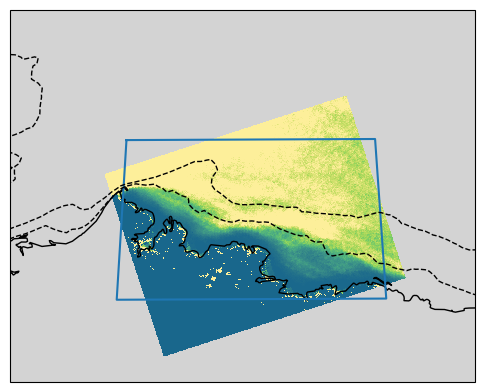

In [9]:

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-153)), figsize=(6,6))
ax.set_facecolor('lightgray')
ax.coastlines(zorder=1)
# ax.gridlines()

ax.set_xlim(-250000,250000)
ax.set_ylim(-2300000,-1900000)

ax.contour(XX, YY, ds.avg.values[ai:aj, bi:bj],
           levels=[ -50,-20], colors=['k'], linewidths=[1,1], 
           linestyles='dashed', zorder=100, transform=data['sic']['proj'])


# ax.contour(XX, YY, ds.avg.values[ai:aj, bi:bj],
#            levels=[-18], colors=['r'], linewidths=[0.5,1, 1, 0.5], 
#            linestyles='dashed', zorder=100, transform=data['sic']['proj'])

# ax.pcolormesh(XX, YY, LAND_CROP, cmap=matplotlib.colors.ListedColormap(['None', 'gray']), 
#               zorder=100, transform=data['sic']['proj'])


# #==============
# src = longterm_freq
# #==============

# s = 2
# ddj = src[s:-s,2*s:] - src[s:-s,:-2*s]
# ddi = src[2*s:,s:-s] - src[:-2*s,s:-s]
# dds = np.sqrt(ddi**2 + ddj**2)

# ax.pcolormesh(lons[s:-s,s:-s], lats[s:-s,s:-s], dds,
#                vmin=0, vmax=0.1, cmap='viridis',
#               transform=ccrs.PlateCarree(), zorder=0)


# ax.pcolormesh(lons, lats, curr_map, cmap = lead_cmap,
#               transform=ccrs.PlateCarree(), zorder=0)


# ax.pcolormesh(lon_xx, lat_yy, new_leads, cmap=matplotlib.colors.ListedColormap(['None', 'k']), 
#               transform = data['sic']['proj'])


newcmap = cmocean.tools.crop_by_percent(cmocean.cm.haline, 30, which='min', N=None)
ax.pcolormesh(lons, lats, longterm_freq,
               vmin=0.00, vmax=0.15, cmap=newcmap,
              transform=ccrs.PlateCarree(), zorder=0)

# ax.pcolormesh(data['sic']['xx'], data['sic']['yy'], data['sic']['sic'],
#                vmin=0, vmax=100, cmap=cmocean.cm.ice,
#               transform=data['sic']['proj'], zorder=0)



# ax.scatter(data['sic']['xx'][data['sic']['sic'] < 50], 
#            data['sic']['yy'][data['sic']['sic'] < 50],
#            c='r',transform=data['sic']['proj'], zorder=0)

# ax.contour(data['sic']['xx'], data['sic']['yy'], data['sic']['sic'],
#             levels = [50], colors=['gold'], transform=data['sic']['proj'], zorder=0)

# ax.pcolormesh(lons, lats, CYC_freq-longterm_freq,
#                vmin=-0.25, vmax=0.25, cmap='RdBu_r',
#               transform=ccrs.PlateCarree(), zorder=0)


out = ccrs.PlateCarree().transform_points(data['sic']['proj'], data['sic']['xx'], data['sic']['yy'])
data['sic']['lon'] = out[:,:,0]
data['sic']['lat'] = out[:,:,1]

lon_range = (data['sic']['lon'] > -156.5) & (data['sic']['lon'] < -149)
lat_range = (data['sic']['lat'] > 70.35) & (data['sic']['lat'] < 71.85)
# top left corner to remove, otherwise Chukchi Plateau gets addes to middle shelf region
cut_corner = (data['sic']['lat'] > 71.65) & (data['sic']['lon'] < -155.5)
flaw_range = ((((ds.avg.values<-20) & (ds.avg.values>-50)) & lon_range) & lat_range) & (cut_corner==False)
# lfbo_range = ((((ds.avg.values<-3) & (ds.avg.values>-15)) & lon_range) & lat_range) & (cut_corner==False)
lfbo_range = ((((ds.avg.values<-4) & (ds.avg.values>-20)) & lon_range) & lat_range) & (cut_corner==False)


# ax.scatter(data['sic']['xx'][lfbo_range], data['sic']['yy'][lfbo_range],
#             c='darkgray', s=5, transform=data['sic']['proj'], zorder=10)

# ax.scatter(data['sic']['xx'][flaw_range], data['sic']['yy'][flaw_range],
#             c='gray', s=5, transform=data['sic']['proj'], zorder=10)


# lon_range = (data['sic']['lon'] > -156.5) & (data['sic']['lon'] < -149.5)
# lat_range = (data['sic']['lat'] > 70.35) & (data['sic']['lat'] < 71.85)
# flaw_range = (((ds.avg.values<-20) & (ds.avg.values>-100)) & lon_range) & lat_range
# lfbo_range = (((ds.avg.values<-3) & (ds.avg.values>-15)) & lon_range) & lat_range


# ax.scatter(lons.values[middle], lats.values[middle],
#             c='darkgray', s=5, transform=ccrs.PlateCarree(), zorder=10)

# ax.scatter(lons.values[inner], lats.values[inner],
#             c='gray', s=5, transform=ccrs.PlateCarree(), zorder=10)


# ax.plot(np.full(10,-156.5), np.linspace(70,73,10), transform=ccrs.PlateCarree(), c='gray')

# # ax.plot(np.full(10,-156), np.linspace(70,73,10), transform=ccrs.PlateCarree(), c='gray')
# # ax.plot(np.linspace(-156.5,-149.5,10), np.full(10,71.65), transform=ccrs.PlateCarree())

# # ax.plot(np.full(10,-143), np.linspace(70,73,10), transform=ccrs.PlateCarree())
# ax.plot(np.full(10,-149.25), np.linspace(70,73,10), transform=ccrs.PlateCarree(), c='gray')
# ax.plot(np.linspace(-156.5,-149.5,10), np.full(10,70.35), transform=ccrs.PlateCarree(), c='gray')
# ax.plot(np.linspace(-156.5,-149.5,10), np.full(10,71.85), transform=ccrs.PlateCarree(), c='gray')


corner_lons = np.array([-156.5, -149, -149, -156.5, -156.5])
corner_lats = np.array([71.85, 71.85, 70.35, 70.35, 71.85])

ax.plot(corner_lons, corner_lats, transform=ccrs.Geodetic())

# ax.pcolormesh(lons, lats, CYC_cloud-longterm_cloud,
#                vmin=-0.25, vmax=0.25, cmap='RdBu_r',
#               transform=ccrs.PlateCarree(), zorder=0)


In [10]:
# date = datetime(2017,1,2)

# # open sic data
# data['sic'] = UNISIC.open_local_file(date, res='6250', hem='n', 
#                                      main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                                      coordinates=False, area=False, include_units=False, quiet=True)

# # open lead file
# #0=clouds, 1=land, 2=sea ice, 3=artefacts, 4=leads, 5=open water.
# lons, lats, dates, lead_map = open_local_lead_file(date.year, crop_i = [1580, 2080], crop_j = [680, 980])


Text(0, 0.5, 'area\nsq. km')

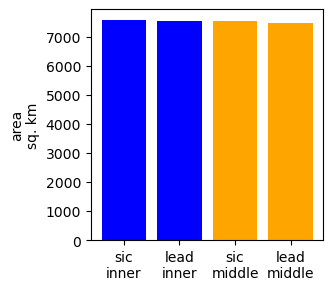

In [11]:
# save total areas for each region
ttl_area = {}
ttl_area['sic'] = {}
ttl_area['sic']['inner'] = np.sum(lfbo_range) * 6.25 * 6.25
ttl_area['sic']['middle'] = np.sum(flaw_range) * 6.25 * 6.25
ttl_area['lead'] = {}
ttl_area['lead']['inner'] = np.sum(inner)
ttl_area['lead']['middle'] = np.sum(middle)

fig, ax = plt.subplots(figsize=(3,3))
plt.bar(0, ttl_area['sic']['inner'], color='b')
plt.bar(1, ttl_area['lead']['inner'], color='b')
plt.bar(2, ttl_area['sic']['middle'], color='orange')
plt.bar(3, ttl_area['lead']['middle'], color='orange')

ax.set_xticks(np.arange(4))
ax.set_xticklabels(['sic\ninner','lead\ninner','sic\nmiddle','lead\nmiddle', ])
ax.set_ylabel('area\nsq. km')

In [14]:
def check_unusual(current_map):

    # weird case where everything is open water on Feb 2 2010???
    # in that case, fill with nans
    if np.sum(current_map.values == 5) > 30000:
        current_map = np.full(current_map.shape, np.nan)
        
    return current_map

In [ ]:
#===============================
years2 = np.arange(2003, 2023)
#===============================

# mean
#------------------------------------------------- 
atm['clim'] = {}
atm['clim']['mean'] = {}
atm['clim']['std'] = {}

sums = {}
for key in ['u', 'v', 's', 'e', 'n', 'non_nan']:
    sums[key] = np.zeros((361,361))

# add dates from all years
for year in years2:
    
    annual_dates = pd.date_range(datetime(year,1,1), datetime(year,3,31))
    dates = np.append(dates, annual_dates)
    
    data['drift'] = PPdrift.open_local_file(annual_dates,
                                        main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/',
                                        filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                                        include_units = False)
    
    # save number of non nan values
    sums['non_nan'] += np.sum(np.isfinite(data['drift']['u']), axis=0)
    
    # add up annual values
    sums['u'] += np.nansum(data['drift']['u'], axis=0)
    sums['v'] += np.nansum(data['drift']['v'], axis=0)
    sums['s'] += np.nansum(np.sqrt(data['drift']['u']**2 + data['drift']['v']**2), axis=0)
    e, n = PPdrift.convert_vectors(lon = data['drift']['lon'], 
                           u_EASE = data['drift']['u'], 
                           v_EASE = data['drift']['v'])
    sums['e'] += np.nansum(e, axis=0)
    sums['n'] += np.nansum(n, axis=0)
    
print(f'{len(dates)} dates over {len(years2)} years')
dates = pd.to_datetime(dates) 


In [225]:
track_years = {}
track_years['lfbo'] = np.array([date.year for date in large_events['lfbo']])
track_years['flaw'] = np.array([date.year for date in large_events['flaw']])
track_years['lfbo_only'] = np.array([date.year for date in large_events['lfbo_only']])
track_years['flaw_only'] = np.array([date.year for date in large_events['flaw_only']])
track_years['both'] = np.array([date.year for date in large_events['both']])

DSM = {}

for key in track_years.keys():

    # list of distinct years
    dist_year = np.array(list(set(track_years[key])))
    
    for ii in range(len(dist_year)):

        year = dist_year[ii]
        DS = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
        DS.close()

        if ii == 0:
            DSM[key] = DS.sel(time = large_events[key][track_years[key] == year])
        else:
            DS = DS.sel(time = large_events[key][track_years[key] == year])
            DSM[key] = xr.merge([DSM[key], DS])

            
            
group = 'lfbo'
longrid, latgrid = np.meshgrid(DSM[group].longitude, DSM[group].latitude)

U = {}
V = {}
MSL = {}
DC = {}

lat_range = (latgrid < 73) & (latgrid > 70.75)
lon_range = (longrid > -156.5) & (longrid < -149)
era_range = lat_range & lon_range

# region_era = {}

for group in track_years.keys():

    U[group] = {}
    V[group] = {}
    MSL[group] = {}
    
    U[group]['mean'] = DSM[group].u10.mean(dim='time')
    V[group]['mean'] = DSM[group].v10.mean(dim='time')
    MSL[group]['mean'] = DSM[group].msl.mean(dim='time')/100

In [269]:
group = 'flaw_only'
mean_o_speed = np.sqrt(DSM[group].u10**2 + DSM[group].v10**2).mean(dim='time')
speed_o_mean = np.sqrt(DSM[group].u10.mean(dim='time')**2 + DSM[group].v10.mean(dim='time')**2)
dc = speed_o_mean / mean_o_speed


In [17]:
print(len(large_events['lfbo']))
print(len(large_events['lfbo_only']))
print(len(large_events['flaw']))
print(len(large_events['flaw_only']))
print(len(large_events['both']))

63
25
156
118
38


In [226]:
print(len(large_events['lfbo']))
print(len(large_events['lfbo_only']))
print(len(large_events['flaw']))
print(len(large_events['flaw_only']))
print(len(large_events['both']))

58
24
144
110
34


In [259]:
np.nanmean(U[GROUP]['mean'].values[data_range])

-4.630019

In [249]:
longrid

array([[-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75],
       [-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75],
       [-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75],
       ...,
       [-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75],
       [-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75],
       [-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,  179.75]],
      dtype=float32)

## Calc mean SIC over winters (JFM) 2003-2024

In [228]:

dates = np.array([], dtype=np.datetime64)

#===============================
years = np.arange(2003, 2023)
#===============================

# add dates from all years
for year in years:
    dates = np.append(dates, pd.date_range(datetime(year,1,1), datetime(year,3,31)))
    
dates = pd.to_datetime(dates)    

print(f'{len(dates)} dates over {len(years)} years')

1805 dates over 20 years


In [229]:
def calc_open_freq_sic(dates, ai,aj, bi,bj):

    counter = 0
    
    for date in dates:

        # open local sic file
        try:
            sic = UNISIC.open_local_file(date, res = '6250', hem = 'n',
                                          area = False, include_units=False)
            exists = True
            counter+=1
        except:
            exists = False

        if counter == 1:
            
            # mean
            #-------------------------------------------------
            sic_sum = np.zeros(sic['sic'][ai:aj, bi:bj].shape)
            open_sum = np.zeros(sic['sic'][ai:aj, bi:bj].shape)
            non_nan = np.zeros(sic['sic'][ai:aj, bi:bj].shape)
            
        if exists:

            sic_data = np.copy(sic['sic'][ai:aj, bi:bj])

            # record non-nan values, then replace nans with zeros
            non_nan += np.isfinite(sic_data).astype(int)
            sic_data[np.isnan(sic_data)] = 0
            sic_sum += sic_data
            open_sum += (sic_data < 70).astype(int)

        # record progress
        if counter%100 == 0:
            print(f'[{counter}/{len(dates)}] {date}')

    sic_mean = sic_sum/non_nan
    open_freq = open_sum/non_nan
    print('---- mean calculated')

    return sic_mean, open_freq



# # standard deviation
# #-------------------------------------------------
# sic_sum = np.zeros(data['sic']['sic'][ai:aj, bi:bj].shape)
# non_nan = np.zeros(data['sic']['sic'][ai:aj, bi:bj].shape)

# for date in dates:

#     # open local sic file
#     try:
#         sic = UNISIC.open_local_file(date, res = '6250', hem = 'n',
#                                       area = False, include_units=False)
#         exists = True
#     except:
#         exists = False
        
        
#     if exists:
        
#         sic_data = (sic_mean - np.copy(sic['sic'][ai:aj, bi:bj]))**2

#         # record non-nan values, then replace nans with zeros
#         non_nan += np.isfinite(sic_data).astype(int)
#         sic_data[np.isnan(sic_data)] = 0
#         sic_sum += sic_data

# sic_std = np.sqrt(sic_sum/non_nan)

In [230]:
sic_freq = {}
sic_mean = {}

sic_mean['long_term'], sic_freq['long_term'] = calc_open_freq_sic(dates, ai,aj,bi,bj)
sic_mean['lfbo'],sic_freq['lfbo'] = calc_open_freq_sic(large_events['lfbo'], ai,aj,bi,bj)
sic_mean['flaw_only'],sic_freq['flaw_only'] = calc_open_freq_sic(large_events['flaw_only'], ai,aj,bi,bj)

[100/1805] 2004-01-10 00:00:00
[200/1805] 2005-01-19 00:00:00
[300/1805] 2006-01-29 00:00:00
[400/1805] 2007-02-08 00:00:00
[500/1805] 2008-02-18 00:00:00
[600/1805] 2009-02-27 00:00:00
[700/1805] 2010-03-11 00:00:00
[800/1805] 2011-03-21 00:00:00
[900/1805] 2013-03-31 00:00:00
[1000/1805] 2015-01-10 00:00:00
[1100/1805] 2016-01-20 00:00:00
[1200/1805] 2017-01-29 00:00:00
[1300/1805] 2018-02-08 00:00:00
[1400/1805] 2019-02-18 00:00:00
[1500/1805] 2020-02-28 00:00:00
[1600/1805] 2021-03-09 00:00:00
[1700/1805] 2022-03-19 00:00:00


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_86105/2348896941.py:38: RuntimeWarning: invalid value encountered in divide
  sic_mean = sic_sum/non_nan
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_86105/2348896941.py:39: RuntimeWarning: divide by zero encountered in divide
  open_freq = open_sum/non_nan


---- mean calculated
---- mean calculated
[100/110] 2021-03-08 00:00:00
---- mean calculated


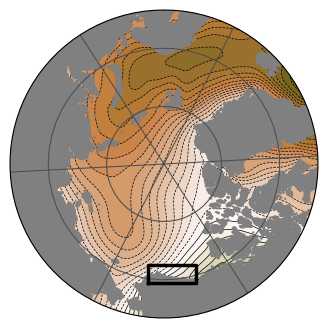

In [3111]:
shelf_map = [-310000.0, 620000.0, -2310000.0, -1972000.0]

def box_from_extent(ax, extent, c = 'k', lw=1,):
    
    x0, x1, y0, y1 = extent
    
    ax.plot([x0, x1, x1, x0, x0],
            [y0, y0, y1, y1, y0], c=c, lw=lw)
    
# shelf_map = list(ax.get_extent())

import matplotlib.path as mpath

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-153)), 
                           figsize=(8,4))
ax.set_facecolor('lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', 
                                            edgecolor='face', facecolor='gray'), zorder=2)
ax.set_xlim(-3000000,3000000)
ax.set_ylim(-3000000,3000000)


# ds2 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/GEBCO/GEBCO_2024/gebco_2024_n90.0_s55.0_w-180.0_e180.0.nc')
# ds2.close()
# sp = 50
# elongrid, elatgrid = np.meshgrid(ds2.lon[::sp], ds2.lat[::sp])
# elevations = ds2.elevation.values[::sp, ::sp]
# norm = matplotlib.colors.TwoSlopeNorm(-300, vmin=-3500, vmax=0)
# cmap = cmocean.tools.crop_by_percent(cmocean.cm.deep_r, 30, which='min', N=None)
# cmap = cmocean.tools.crop_by_percent(cmap, 3, which='max', N=None)
# ax2.pcolormesh(elongrid, elatgrid, elevations,
#               cmap=cmap, norm=norm,
#               zorder=0, transform=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

linekwargs={'c':[0.3,0.3,0.3], 'lw':0.75, 'transform':ccrs.PlateCarree()}
for lon in np.arange(0,360,60):
    ax.plot(np.zeros(10)+lon, np.linspace(60,90,10),**linekwargs )
for lat in [70,80,90]:
    ax.plot(np.linspace(0,360,50), np.zeros(50)+lat, **linekwargs )
    

box_from_extent(ax, shelf_map, c = 'k', lw=2.5)

fig.patch.set_alpha(0.0)




group = 'lfbo_open'

# DATE = date.strftime('%Y-%m-%d')
du = DSM[group].u10.sel(time=events[group]['date']).mean(dim='time') - DSM['clim'].u10.mean(dim='time')
dv = DSM[group].v10.sel(time=events[group]['date']).mean(dim='time') - DSM['clim'].v10.mean(dim='time')
local_msl = DSM[group].msl.sel(time=events[group]['date'], latitude=71, longitude = -153).mean(dim='time')/100
msl_data = DSM[group].msl.sel(time=events[group]['date']).mean(dim='time')/100 - local_msl

# vec_diff = np.sqrt(du**2+dv**2)

newcmap = cmocean.tools.crop_by_percent(cmocean.cm.tarn, 30, which='both', N=None)
mesh = ax.contourf(longrid, latgrid, ma.masked_where(longrid<0.25, msl_data),
           levels = np.arange(-40,41,1), 
            cmap=newcmap, vmin=-20, vmax=20, 
            zorder=0, transform=ccrs.PlateCarree())
mesh = ax.contourf(longrid, latgrid, ma.masked_where(longrid<0.25, msl_data),
           levels = np.arange(-20,21,1), 
            cmap=newcmap, vmin=-20, vmax=20, 
            zorder=0, transform=ccrs.PlateCarree())


# mesh = ax.pcolormesh(longrid, latgrid, msl_data,
#               vmin=-20, vmax=20, cmap=cmocean.cm.balance, zorder=0, transform=ccrs.PlateCarree())

# add_colorbar(fig, ax, [mesh], cb_placement='top', cb_orientation='auto', 
#              cb_width='auto', cb_length_fraction=[0.2,0.8], cb_pad=0.05, cb_ticks=[-20,0,20], 
#              cb_ticklabels='auto', cb_extend='neither', cb_label=u'Δ SLP (hPa)', labelpad='auto', 
#              cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None,
#              cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


color = 'k'#[0.3,0.3,0.3]
ax.contour(longrid, latgrid, ma.masked_where(longrid<0.25, msl_data),
           levels = np.arange(-40,41,1), colors=[color], linewidths=0.5,
              zorder=0, transform=ccrs.PlateCarree())

fig.savefig(f'./figures/map_INSET_atm_{group}.png', dpi=500, bbox_inches='tight', pad_inches=0)#, transparent=True)



In [3065]:
events.keys()

dict_keys(['lfbo_open', 'lfbo_distinct', 'lfbo', 'flaw_open', 'flaw_distinct', 'flaw', 'clim'])

In [ ]:
crop_DS = DS2.sel(pressure_level = 1000).z.sel(latitude=lat_slice, longitude=lon_slice)
crop_DS = crop_DS.rename({'valid_time': 'time'})
(DSalt['ug'],DSalt['vg']) = metpy.calc.geostrophic_wind(crop_DS.drop_vars(['number','pressure_level']))

In [2992]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/dailyJFM_pressure/JFM_pressure_2006.nc')
ds.close()

ds


<xarray.Dataset>
Dimensions:         (valid_time: 90, pressure_level: 2, latitude: 161,
                     longitude: 1440)
Coordinates:
    number          int64 ...
  * pressure_level  (pressure_level) float64 1e+03 850.0
  * latitude        (latitude) float64 90.0 89.75 89.5 89.25 ... 50.5 50.25 50.0
  * longitude       (longitude) float64 -180.0 -179.8 -179.5 ... 179.5 179.8
  * valid_time      (valid_time) datetime64[ns] 2006-01-01 ... 2006-03-31
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-24T01:31 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:


fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-153)), figsize=(6,6))
ax.set_facecolor('lightgray')
ax.coastlines(zorder=1)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='gray'), zorder=10)
# ax.set_title(group)

# ax.set_xlim(-500000,800000)
# ax.set_ylim(-2300000,-1900000)

# ax.set_xlim(-500000,1000000)
# ax.set_ylim(-2800000,-1500000)


ax.set_xlim(-2100000,1800000)
ax.set_ylim(-3250000,300000)


# ax.set_extent([185,225,68,81], crs=ccrs.PlateCarree())





# ax.gridlines()

# abv_dc1 = (atm['flaw']['dc'] - atm['clim']['dc']) > 0.25
# abv_dc2 = (atm['lfbo']['dc'] - atm['clim']['dc']) > 0.25


# ax.pcolormesh(longrid, latgrid, vec_diff,
#               vmin=0, vmax=8, cmap='viridis', zorder=0, transform=ccrs.PlateCarree())



mesh = ax.pcolormesh(longrid, latgrid, msl_data,
              vmin=-20, vmax=20, cmap=cmocean.cm.balance, zorder=0, transform=ccrs.PlateCarree())

add_colorbar(fig, ax, [mesh], cb_placement='bottom', cb_orientation='auto', 
             cb_width='auto', cb_length_fraction=[0.5, 0.9], cb_pad=-0.15, cb_ticks='auto', 
             cb_ticklabels='auto', cb_extend='neither', cb_label='SLP diff (hPa)', labelpad='auto', 
             cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None,
             cb_labelsize=12, draw_edges=False, edge_params=['k', 2])


ax.contour(longrid, latgrid, ma.masked_where(longrid<10, msl_data),
           levels = np.arange(-40,41,2), colors='k',
              zorder=0, transform=ccrs.PlateCarree())


poly_lons = np.array([-156.5, -155, -154, -153, -152, -151, -150, -149,
                      -149, -150,-151,-152,-153,-154,-155, -156.5, 
                      -156.5])
poly_lats = np.array([71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 71.85, 
                      70.35, 70.35, 70.35, 70.35, 70.35, 70.35, 70.35, 70.35,
                      71.85])

ax.plot(poly_lons, poly_lats,lw=2, c='k', zorder=100, transform=ccrs.Geodetic())



# ax.contour(XX, YY, ds.avg.values[ai:aj, bi:bj],
#        levels=[ -50,-20], colors=['gray'], linewidths=[0.75,0.75], 
#        linestyles='solid', zorder=100, transform=sic['proj'])



# # open sic data
# sic = UNISIC.open_local_file(date, res='6250', hem='n', 
#                                      main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                                      coordinates=False, area=False, include_units=False, quiet=True)
# sp = 1
# ax.pcolormesh(sic['xx'][::sp,::sp], sic['yy'][::sp,::sp], sic['sic'][::sp,::sp],
#              vmin=0,vmax=100, cmap=cmocean.cm.ice, transform=sic['proj'], zorder=-1)
# ax.contour(sic['xx'][::sp,::sp], sic['yy'][::sp,::sp], sic['sic'][::sp,::sp],
#            levels=[68], colors='gold', linewidths=0.5, transform=sic['proj'], zorder=-1)


# drift = PPdrift.open_local_file(date,
#                                     main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/',
#                                     filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
#                                     include_units = False)


quiverkwargs = {'scale_units':'xy', 'scale':0.00008, 'width':0.002, 'headwidth':5, 'color':'k'}
sp = 8
qv = ax.quiver(drift['xx'][::sp,::sp], drift['yy'][::sp,::sp], 
              OSM[group]['u'].mean(dim='time').values[::sp,::sp], 
              OSM[group]['v'].mean(dim='time').values[::sp,::sp], 
              transform=drift['proj'], **quiverkwargs, zorder=100)



line_kwargs = {'lw':0.5, 'c':'k'}
for lat in np.arange(60,91,10):
    ax.plot(np.linspace(0,360,100), np.full(100, lat),**line_kwargs, transform=ccrs.PlateCarree())
for lon in np.arange(0,361,45):
    ax.plot(np.full(100, lon), np.linspace(55,90,100), **line_kwargs, transform=ccrs.PlateCarree())

    